## TS4 - Camila Belen Smith
## Primeras nociones de estimación espectral.

En esta tarea se busca analizar el desempeño de distintos estimadores de amplitud y frecuencia aplicados a una señal sinusoidal sumada a ruido blanco. A partir de 200 realizaciones con distintas condiciones de SNR (3 y 10 dB), se estudia cómo influyen tanto el tipo de ventana utilizada como la variabilidad del ruido en el sesgo y la varianza de los estimadores. Se consideran ventanas como la rectangular, Flattop y Blackman-Harris, entre otras. El objetivo es obtener una primera aproximación práctica al análisis espectral y la comparación entre diferentes métodos de estimación.


### Librerias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd

### Funciones

In [20]:
def gen_fft(xk,fs,cte =None, axis=0): #Este lo describo bien xq seguro lo voy a volver a usar en la materia :) asi me queda :)
    """
    Calcula la FFT normalizada, la grilla espectral y el filtro (Bool) de Nyquist para quedarme con la mitad (ya que la FFT es simetrica)
    inputs :)
    
    xk : Señal de entrada (puede ser un vector o matriz)
    fs : Frecuencia de muestreo [Hz]
    cte : Cantidad de puntos a calcular en la FFT (por defecto N) pero para padding se puede cambiar :)
    axis : Eje a lo largo del cual se calcula la FFT (por defecto 0)

    outputs :)
    Xk_fft : FFT normalizada (espectro)
    ffx : Grilla espectral [Hz]
    bfrec : Filtro de Nyquist (booleano) (True si la frecuencia es menor a fs/2)
   
    """
    N = xk.shape[axis] 
    if cte is None:
            cte = N

    df = fs / cte

    Xk_fft = np.fft.fft(xk,n = cte, axis=axis) / N  
    ffx = np.linspace(0, (cte-1)*df, cte)
    bfrec = ffx <= (fs / 2)
    return Xk_fft, ffx, bfrec, df

def plot_temp(xx,t, repes, title, xlabel, ylabel, label = None):
    for i in range(repes): 
        plt.plot(t, xx[:,i], alpha=0.5, label=label[i] if label is not None else None)
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.grid()

def plot_freq(Xk_fft, ffx,repes, bfrec, title, xlabel, ylabel):
    for i in range(repes):
        plt.plot(ffx[bfrec], 10 * np.log10(2 * np.abs(Xk_fft[bfrec, i])**2), alpha=0.5)
    
    plt.title(title)
    plt.xlabel(xlabel)  
    plt.ylabel(ylabel)
    plt.grid()

def estimador_a(Xk_fft, f0):
     '''
     a_est: vector de amplitudes estimadas
     a_media: media de las amplitudes estimadas
     a_var: varianza de las amplitudes estimadas

     '''

     lim = int(f0) 
     a_est = np.abs(Xk_fft[lim, :])
     a_media = np.mean(a_est)
     a_var = np.var(a_est)
     return a_est, a_media, a_var

def estimador_w(X_fft, bfrec, df):
    z = np.argmax(np.abs(X_fft[bfrec, :]), axis=0) * df
    z_media = np.mean(z)
    z_var = np.var(z)
    return z, z_media, z_var


#### Generacion de la señal

Se generaron 200 realizaciones de una señal sinusoidal de 1000 muestras. La frecuencia base es de 250 Hz (fs/4), pero se le suma una pequeña perturbación aleatoria uniforme entre -0.5 y 0.5 Hz. La señal tiene una amplitud $ a_1 = \sqrt{2} $, para que su potencia sea 1 W.

La variable de tiempo tiene dimensión [1000 x 1] y la matriz de frecuencias aleatorias [1 x 200], lo que permite generar la matriz de señales $ x(n) $ como una matriz de dimensión [1000 x 200].

Luego, se generó ruido gaussiano blanco aditivo con dos niveles de potencia, correspondientes a SNR de 10 dB y 3 dB. El ruido también tiene dimensión [1000 x 200]. Al sumar este ruido a la señal limpia se obtienen dos versiones de la señal ruidosa: `xk` (SNR 10 dB) y `xk_2` (SNR 3 dB).


In [3]:
repes = 200 #Son las realizaciones del experimento
a1= np.sqrt(2) #para q la señal sea normalizada (TS3)
N=1000
fs=1000
ts=1/fs
df = fs/N

#### Matriz de ruido

In [4]:
SNR= 10
SNR_2 = 3
Pot_nn =10**(-SNR / 10) # Viene de (*)
Pot_nn_2 = 10**(-SNR_2 / 10) # Viene de (*)
verifico = - 10 * np.log10(Pot_nn)
verifico_2 = - 10 * np.log10(Pot_nn_2)
print('SNR: ',verifico)
print('SNR_2: ',verifico_2)
N = 1000
sigma = np.sqrt(Pot_nn)
sigma_2 = np.sqrt(Pot_nn_2)
nn = np.random.normal(0, sigma, (N,repes)) #[1000 X 200]
nn_2 = np.random.normal(0, sigma_2, (N,repes)) #[1000 X 200]
print('shape del ruido: ',nn.shape)
print('shape del ruido 2: ',nn_2.shape)

SNR:  10.0
SNR_2:  3.0000000000000004
shape del ruido:  (1000, 200)
shape del ruido 2:  (1000, 200)


( * ) $SNR_{dB}  = 10 Log_{10} \frac{P_s}{P_n} $ Si depejo $P_n$ obtengo lo de (*)

Siendo $P_s$ la potencia de la señal y $P_n$ la potencia del ruido

#### Matriz de Omegas

In [5]:
ff = np.array([]) #llamo ff a la matriz de frecuencias
for i in range(repes):
    fr = np.random.uniform(-0.5,0.5) 
    f0= fs/4 #250
    f1= f0 + fr * df #f0 + ruido
    ff = np.append(ff,f1)
    
ff = ff.reshape((1,repes)) # [1 X 200]
print('shape de la matriz de frecuencias: ',ff.shape)

shape de la matriz de frecuencias:  (1, 200)


#### Matriz de la señal temporal

In [6]:
t = np.linspace(0,(N-1)*ts,N).reshape((N,1)) #[1000 X 1] queda bien ya que tengo que hacer ff * t
xx = a1 * np.sin(2*np.pi*t*ff) #[1000 X 200]
xk= xx + nn #SNR 10
xk_2 = xx + nn_2 #SNR 3
print('shape de la señal: ',xk.shape)
print('shape de la señal 2: ',xk_2.shape)

shape de la señal:  (1000, 200)
shape de la señal 2:  (1000, 200)


### Ploteo 1 realizacion para ver como es
$xx$ es la señal sinusoidal, la frecuencia base es de 250Hz (fs/4), pero se le suma una pequeña perturbacion aleatoria uniforme entre -0.5 y 0.5 Hz.

$nn$ es el ruido  gaussiano blanco aditivo con dos niveles de potencia, correspondientes a SNR de 10 dB y 3 dB.

$xk = xx + nn $

Ploteo la señal de 0 a 0.3 segundos para que se vea bien. 

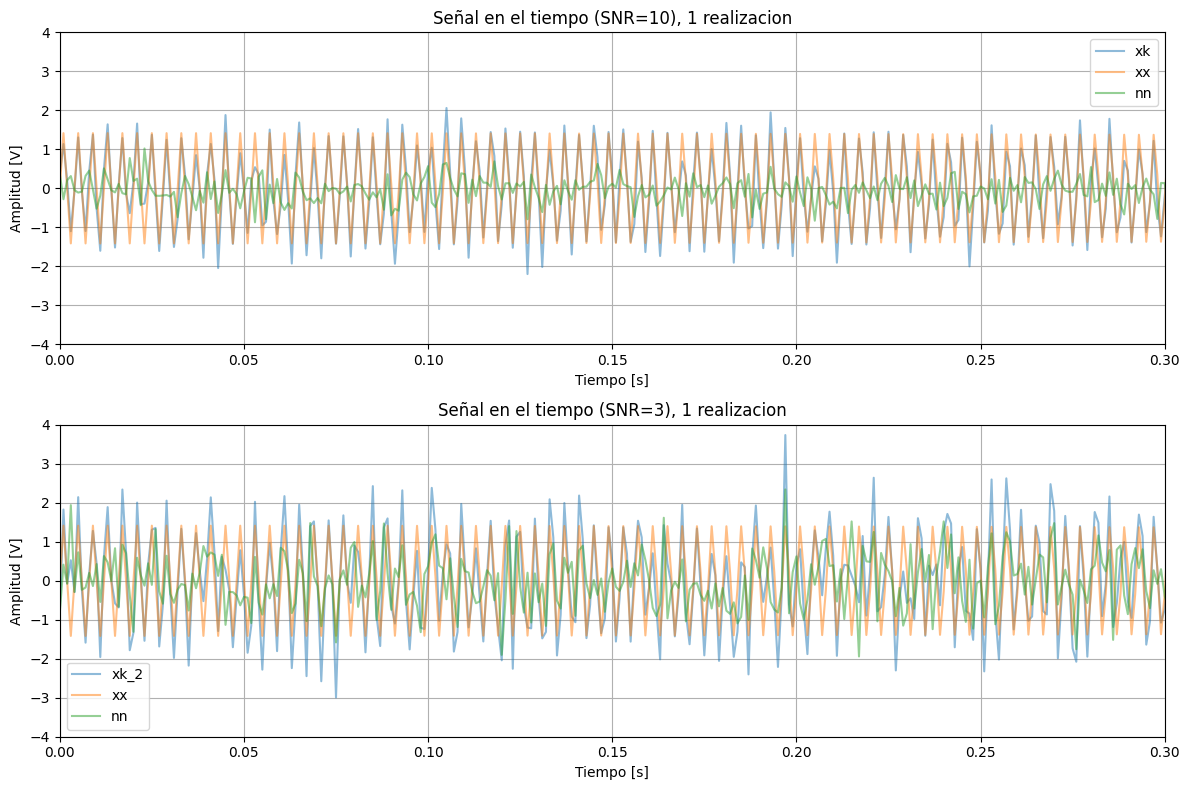

In [30]:
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plot_temp(xk, t, 1, 'Señal en el tiempo (SNR=10), 1 realizacion', 'Tiempo [s]', 'Amplitud [V]', label = ['xk'])
plot_temp(xx, t, 1, 'Señal en el tiempo (SNR=10), 1 realizacion', 'Tiempo [s]', 'Amplitud [V]', label = ['xx'])
plot_temp(nn, t, 1, 'Señal en el tiempo (SNR=10), 1 realizacion', 'Tiempo [s]', 'Amplitud [V]', label = ['nn'])
plt.legend()
plt.ylim(-4, 4)
plt.xlim(0,0.3)
plt.subplot(2, 1, 2)
plot_temp(xk_2, t, 1, 'Señal en el tiempo (SNR=3), 1 realizacion', 'Tiempo [s]', 'Amplitud [V]', label= ['xk_2'])
plot_temp(xx, t, 1, 'Señal en el tiempo (SNR=3), 1 realizacion', 'Tiempo [s]', 'Amplitud [V]', label = ['xx'])
plot_temp(nn_2, t, 1, 'Señal en el tiempo (SNR=3), 1 realizacion', 'Tiempo [s]', 'Amplitud [V]', label = ['nn'])
plt.xlim(0,0.3)
plt.legend()
plt.ylim(-4, 4)
plt.tight_layout()
plt.show()

Le di a ambos graficos la misma escala para que se pueda observar la diferencia del SNR. El SNR = 3 presenta mucho mas ruido gausiano que SNR = 10. 

El $xx$ de ambas señales son iguales, no cambian. 

# Windows

#### ¿Para que sirven?
Lo explico en un ejemplo limpio y simple sin ruido.
Cuando se analiza una señal sinusoideal de 15 Hz con $f_s=1000$ y $N=1000$ (resolucion espectral: 1Hz), no se observa fuga espectral porque la frecuencia de la señal coincide exactamente con un bin de la DFT. En cambio, para una señal de 15.5 Hz, la frecuencia no cae en un bin entero, y la energía se reparte entre múltiples frecuencias. Esto genera **fuga espectral**, visible como una expansión del pico principal y la aparición de lóbulos secundarios (Se ve a continuación). Este efecto se debe al ventaneo implícito (Ventana rectangular) en la DFT y puede acentuarse o atenuarse según la ventana utilizada.
A continuacion dejo un mini ejemplo (es de unas clases atras) de las ventajas (y desventajas tambien) de utilizar una ventana.

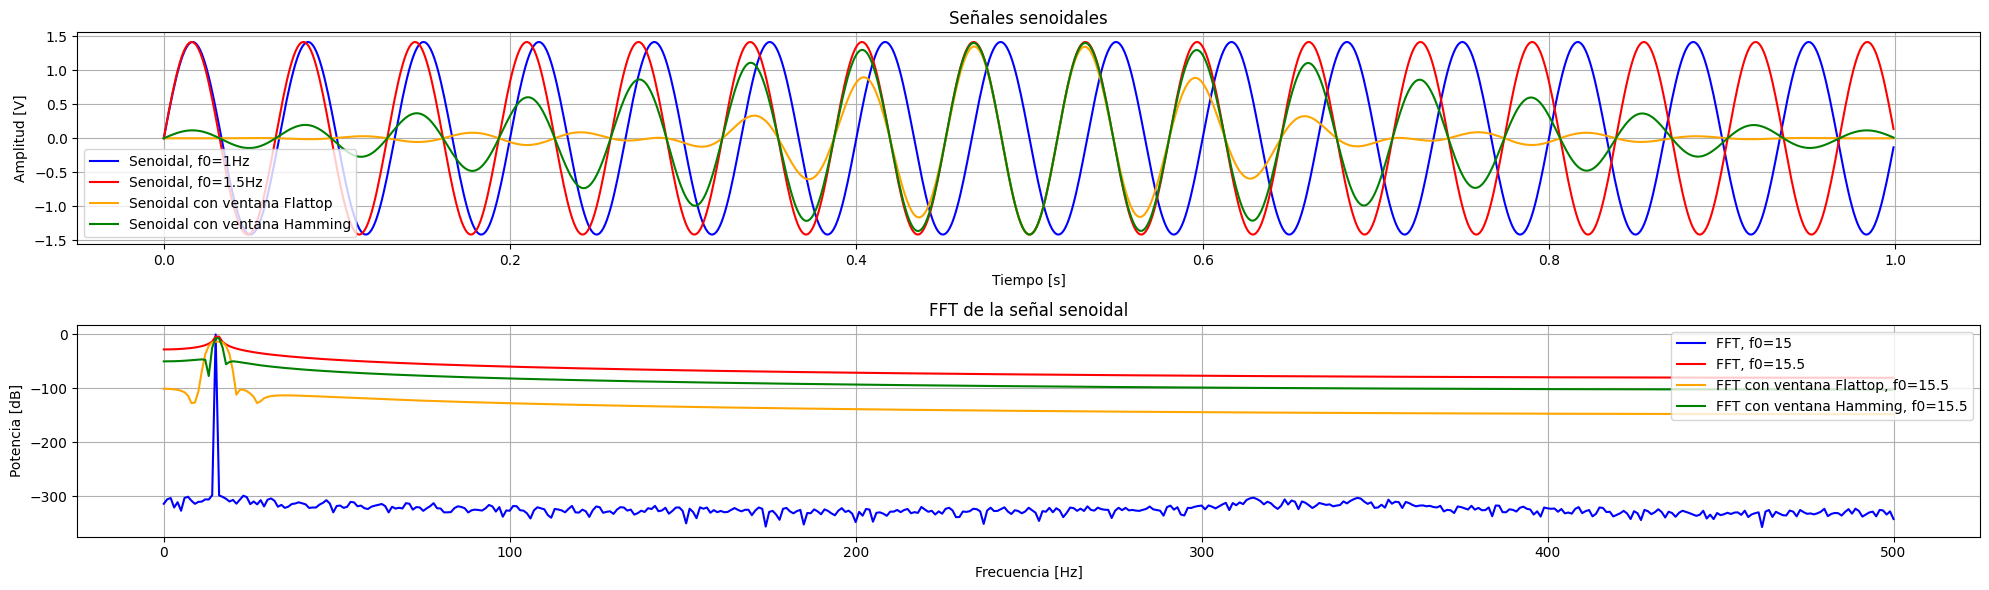

In [31]:
import Aps 
tt_pd, xx_pd = Aps.generador_sen(np.sqrt(2), 0, ff=15, ph=0, nn=N, fs=fs)
tt_pd_2, xx_pd_2 = Aps.generador_sen(np.sqrt(2), 0, ff=15.5, ph=0, nn=N, fs=fs)
plt.figure(figsize=(20, 6))
plt.subplot(2,1,1)
plt.plot(tt_pd, xx_pd, label=f'Senoidal, f0=1Hz', color='blue')
plt.plot(tt_pd, xx_pd_2, label=f'Senoidal, f0=1.5Hz', color='red')
plt.plot(tt_pd,xx_pd_2 *signal.windows.flattop(N, sym=True), label='Senoidal con ventana Flattop', color='orange')
plt.plot(tt_pd,xx_pd_2 *signal.windows.hamming(N, sym=True), label='Senoidal con ventana Hamming', color='green')
plt.title('Señales senoidales')
plt.xlabel('Tiempo [s]')
plt.ylabel('Amplitud [V]')
plt.legend()
plt.grid()

plt.subplot(2,1,2)
ffx = np.linspace(0, (N-1)*df, N)   #eje frecuencial
bfrec = ffx <= fs/2 #es un booleano, m quedo solo con la mitad (redundante ambos lados del espectro)

ft_As = 1/N * np.fft.fft(xx_pd_2)
ft_As_1 = 1/N * np.fft.fft(xx_pd)
ft_As_w = 1/N * np.fft.fft(xx_pd_2 * signal.windows.flattop(N, sym=True))
ft_As_w_2 = 1/N * np.fft.fft(xx_pd_2 * signal.windows.hamming(N, sym=True))

plt.plot(ffx[bfrec], 10 * np.log10(2 * np.abs(ft_As_1[bfrec])**2), label='FFT, f0=15', color='blue')
plt.plot(ffx[bfrec], 10 * np.log10(2 * np.abs(ft_As[bfrec])**2), label='FFT, f0=15.5', color='red')
plt.plot(ffx[bfrec], 10 * np.log10(2 * np.abs(ft_As_w[bfrec])**2), label='FFT con ventana Flattop, f0=15.5', color='orange')
plt.plot(ffx[bfrec], 10 * np.log10(2 * np.abs(ft_As_w_2[bfrec])**2), label='FFT con ventana Hamming, f0=15.5', color='green')
plt.title('FFT de la señal senoidal')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Potencia [dB]')
plt.legend(loc = 'upper right')

plt.grid()
plt.tight_layout()
plt.show()

Cada ventana tiene sus pros y contras. Por ejemplo, la Flat Top sirve cuando nos importa medir bien la amplitud del pico, pero pierde mucha resolución (el pico se ensancha). La Hamming y la Hann son más equilibradas: bajan bastante la fuga (lóbulos laterales más bajos) sin ensanchar tanto el pico. La rectangular, que es la que usa la DFT por defecto, tiene el pico más fino, pero la mayor fuga. En resumen, elegir una ventana es decidir qué queremos priorizar: que el pico sea más fino (mejor resolución en frecuencia) o que no haya tanta fuga (mejor limpieza del espectro).

## Voy a Ventanear con distintas Windows a mi señal $x_k$

Decidi probar que pasa si ventaneo con 6 windows, que son las siguientes:
- Flattop
- Blackmanharris
- Barlett
- Hann
- Triangular
- Box (implicita)

Antes voy a plotear a las 6 windows para ver como son

In [40]:
from scipy.fft import fft, fftshift

window_length = 51  
fft_points = 2048  

windows = {
    "Boxcar": signal.windows.boxcar(window_length),
    "Flattop": signal.windows.flattop(window_length),
    "Blackman-Harris": signal.windows.blackmanharris(window_length),
    "barlett": signal.windows.bartlett(window_length),
    "Hann": signal.windows.hann(window_length),
    "Triangular": signal.windows.triang(window_length)
}

colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']


plt.figure(figsize=(10, 8))


plt.subplot(2, 1, 1)
for (name, window), color in zip(windows.items(), colors):
    plt.plot(window, label=name, color=color)
plt.title("Ventanas en el dominio temporal")
plt.ylabel("Amplitud")
plt.xlabel("Muestra")
plt.legend()
plt.grid()


plt.subplot(2, 1, 2)
for (name, window), color in zip(windows.items(), colors):
    A = fft(window, fft_points) / (len(window) / 2.0)
    freq = np.linspace(-0.5, 0.5, len(A))
    response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))
    plt.plot(freq, response, label=name, color=color)
plt.title("Respuesta en frecuencia de las ventanas")
plt.ylabel("Magnitud normalizada [dB]")
plt.xlabel("Frecuencia normalizada [ciclos por muestra]")
plt.axis([-0.5, 0.5, -150, 0])
plt.legend(loc = 'upper right')  
plt.grid()

plt.tight_layout()
plt.show()

C:\Users\Notebook\AppData\Local\Temp\ipykernel_5272\1393079369.py:35: RuntimeWarning: divide by zero encountered in log10
  response = 20 * np.log10(np.abs(fftshift(A / abs(A).max())))


Saque el codigo de : https://docs.scipy.org/doc/scipy/reference/signal.windows.html

Aclaro, plotie con N y Fs distintos del trabajo, mi objetivo era mostrar las ventanas nada mas. 

## Ahora si, ventaneo mi señal :)

In [42]:

xk_flattop = xk * signal.windows.flattop( N , sym = True ).reshape(-1,1)  # conv con windoow
xk_blackh = xk * signal.windows.blackmanharris(N, sym=True).reshape(-1,1)
xk_barlett = xk * signal.windows.bartlett(N, sym=True).reshape(-1,1)
xk_han= xk * signal.windows.hann(N, sym=True).reshape(-1,1)
xk_triang = xk * signal.windows.triang(N, sym=True).reshape(-1,1)
w = 6 # cantidad de windws (+ implicita)

#Ahora para SNR 3
xk_flattop_2 = xk_2 * signal.windows.flattop( N , sym = True ).reshape(-1,1)  # conv con windoow
xk_blackh_2 = xk_2 * signal.windows.blackmanharris(N, sym=True).reshape(-1,1)
xk_barlett_2 = xk_2 * signal.windows.bartlett(N, sym=True).reshape(-1,1)
xk_han_2= xk_2 * signal.windows.hann(N, sym=True).reshape(-1,1)
xk_triang_2 = xk_2 * signal.windows.triang(N, sym=True).reshape(-1,1)

## FFT'S

In [43]:
## Aca todas tienen igual ffx, bfrec y df ya que no hay padding por eso a todas las llame igual :)
Xk_fft, ffx, bfrec, df = gen_fft(xk,fs=fs)
Xk_flattop_fft, ffx, bfrec, df = gen_fft(xk_flattop,fs=fs)
Xk_blackh_fft, ffx, bfrec, df = gen_fft(xk_blackh,fs=fs)
Xk_barlett_fft, ffx, bfrec, df = gen_fft(xk_barlett,fs=fs)
Xk_han_fft, ffx, bfrec, df = gen_fft(xk_han, fs=fs)
Xk_triang_fft, ffx, bfrec, df = gen_fft(xk_triang, fs=fs)

#Ahora para SNR 3
Xk_2_fft, ffx, bfrec, df = gen_fft(xk_2,fs=fs)
Xk_flattop_2_fft, ffx, bfrec, df = gen_fft(xk_flattop_2,fs=fs)
Xk_blackh_2_fft, ffx, bfrec, df = gen_fft(xk_blackh_2,fs=fs)
Xk_barlett_2_fft, ffx, bfrec, df = gen_fft(xk_barlett_2,fs=fs)
Xk_han_2_fft, ffx, bfrec, df = gen_fft(xk_han_2, fs=fs)
Xk_triang_2_fft, ffx, bfrec, df = gen_fft(xk_triang_2, fs=fs)


## Ploteo señales temporales post aplicarles la ventana

Voy a plotear solamente 1 asi se observa bien el efecto de la ventana y las modulaciones sobre la señales en el dominio temporal

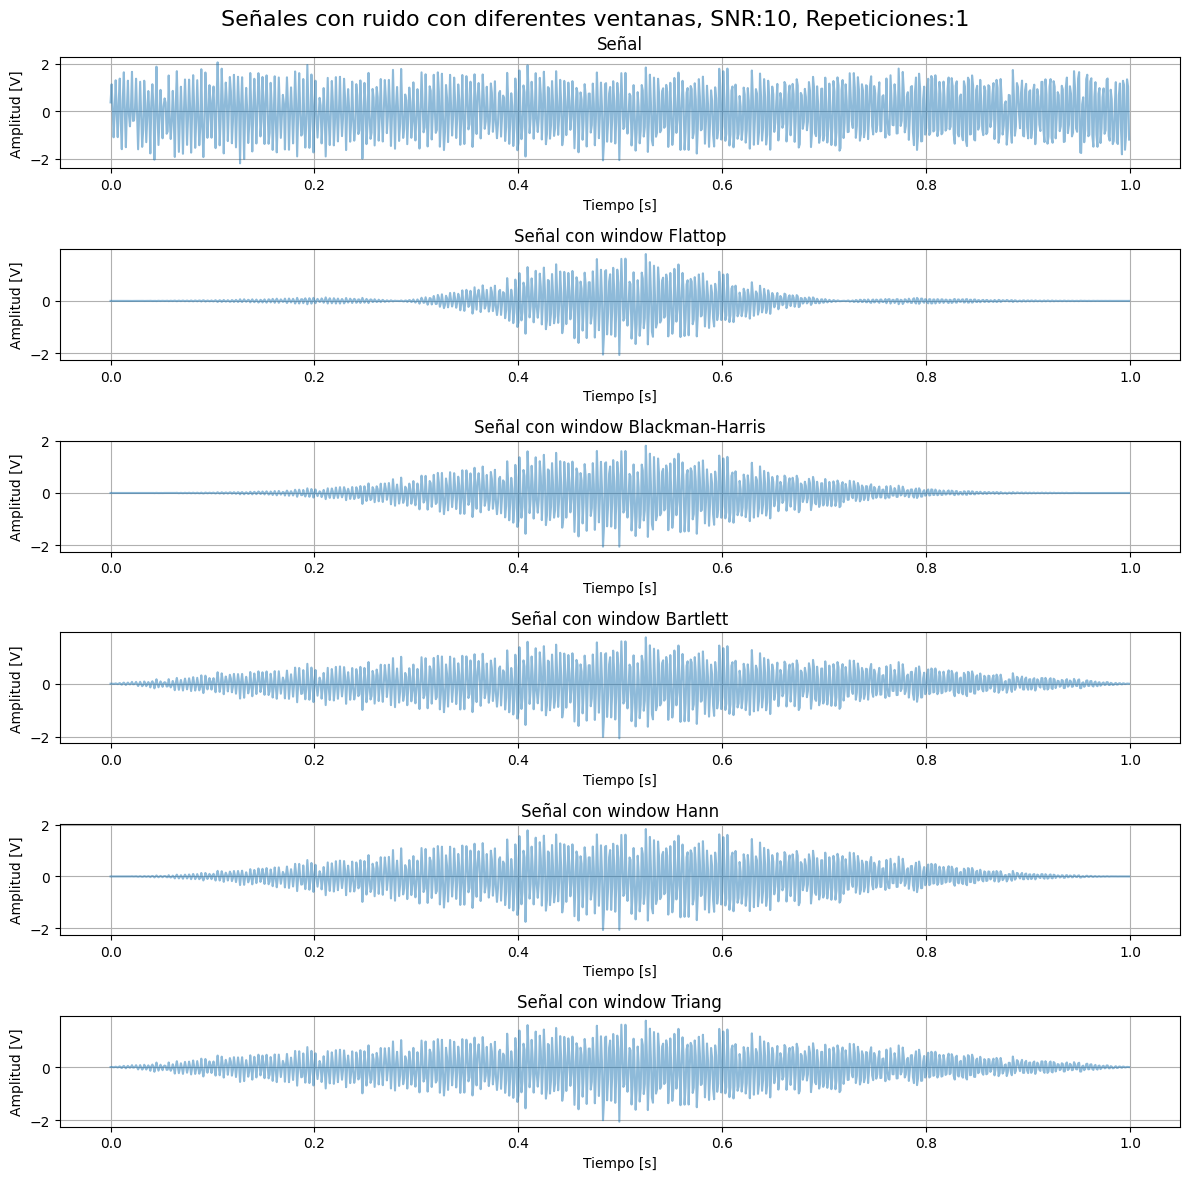

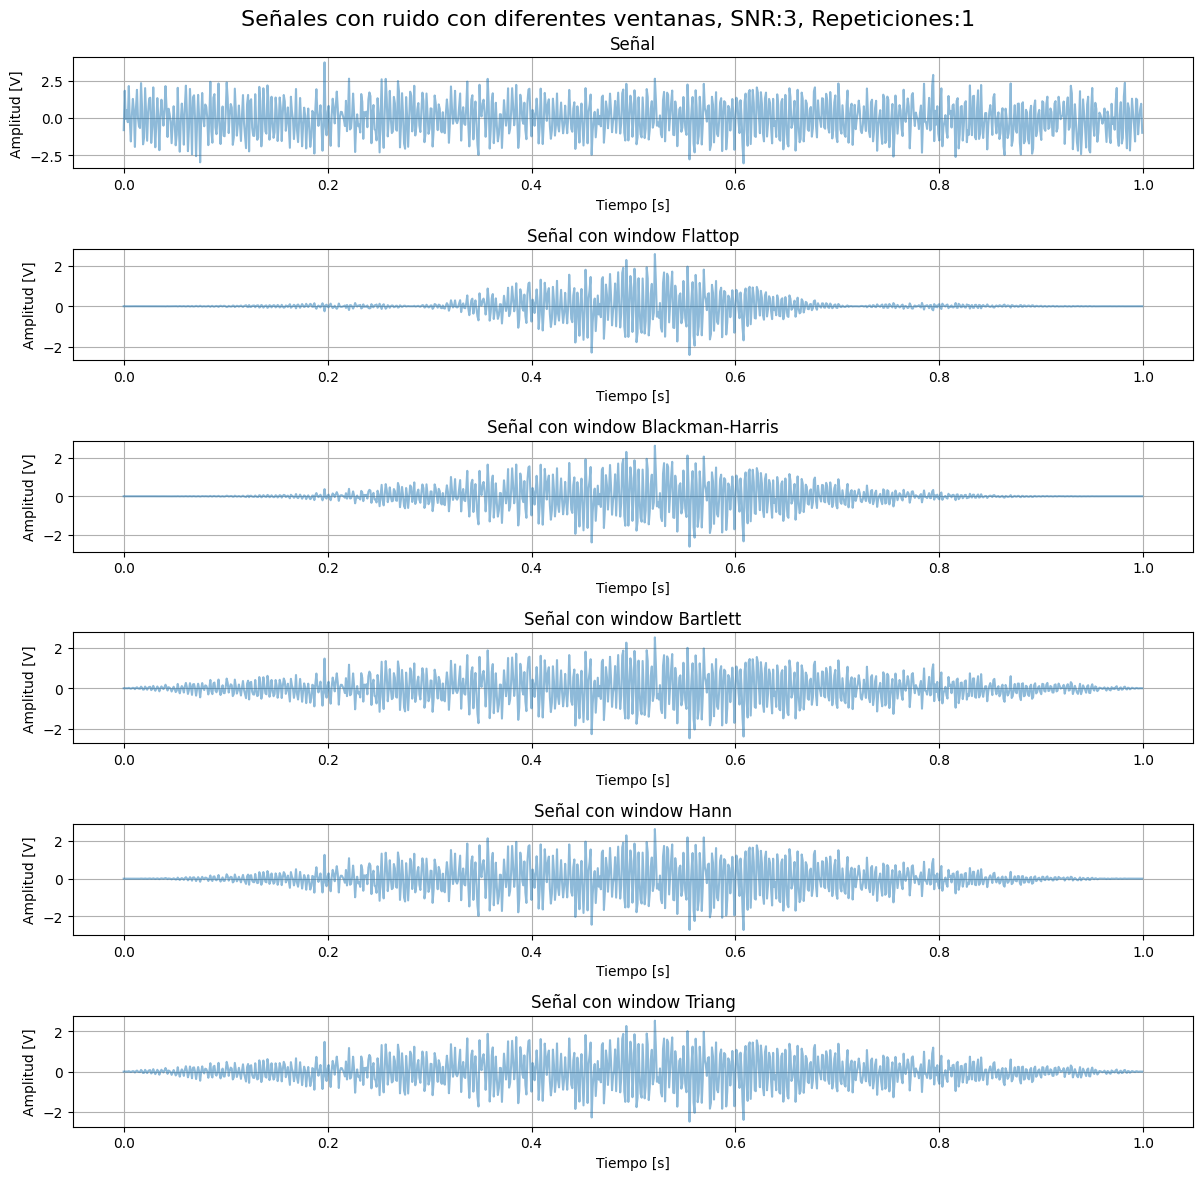

In [44]:
plt.figure(figsize=(12, 12))
repes =1
plt.subplot(w,1,1)
plot_temp(xk,t, repes, 'Señal', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,2)
plot_temp(xk_flattop,t, repes, 'Señal con window Flattop', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,3)
plot_temp(xk_blackh,t, repes, 'Señal con window Blackman-Harris', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,4)
plot_temp(xk_barlett,t, repes, 'Señal con window Bartlett', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,5)
plot_temp(xk_han,t, repes, 'Señal con window Hann', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,6)
plot_temp(xk_triang,t, repes, 'Señal con window Triang', 'Tiempo [s]', 'Amplitud [V]')
plt.suptitle(f'Señales con ruido con diferentes ventanas, SNR:{SNR}, Repeticiones:{repes}', fontsize=16)
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 12))
plt.subplot(w,1,1)
plot_temp(xk_2,t, repes, 'Señal', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,2)
plot_temp(xk_flattop_2,t, repes, 'Señal con window Flattop', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,3)
plot_temp(xk_blackh_2,t, repes, 'Señal con window Blackman-Harris', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,4)
plot_temp(xk_barlett_2,t, repes, 'Señal con window Bartlett', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,5)
plot_temp(xk_han_2,t, repes, 'Señal con window Hann', 'Tiempo [s]', 'Amplitud [V]')
plt.subplot(w,1,6)
plot_temp(xk_triang_2,t, repes, 'Señal con window Triang', 'Tiempo [s]', 'Amplitud [V]')
plt.suptitle(f'Señales con ruido con diferentes ventanas, SNR:{SNR_2}, Repeticiones:{repes}', fontsize=16)
plt.tight_layout()
plt.show()


## Ploteo espectros

De las 200 realizaciones que hice, voy a plotear 5 nada mas. Para poder analizar los espectros

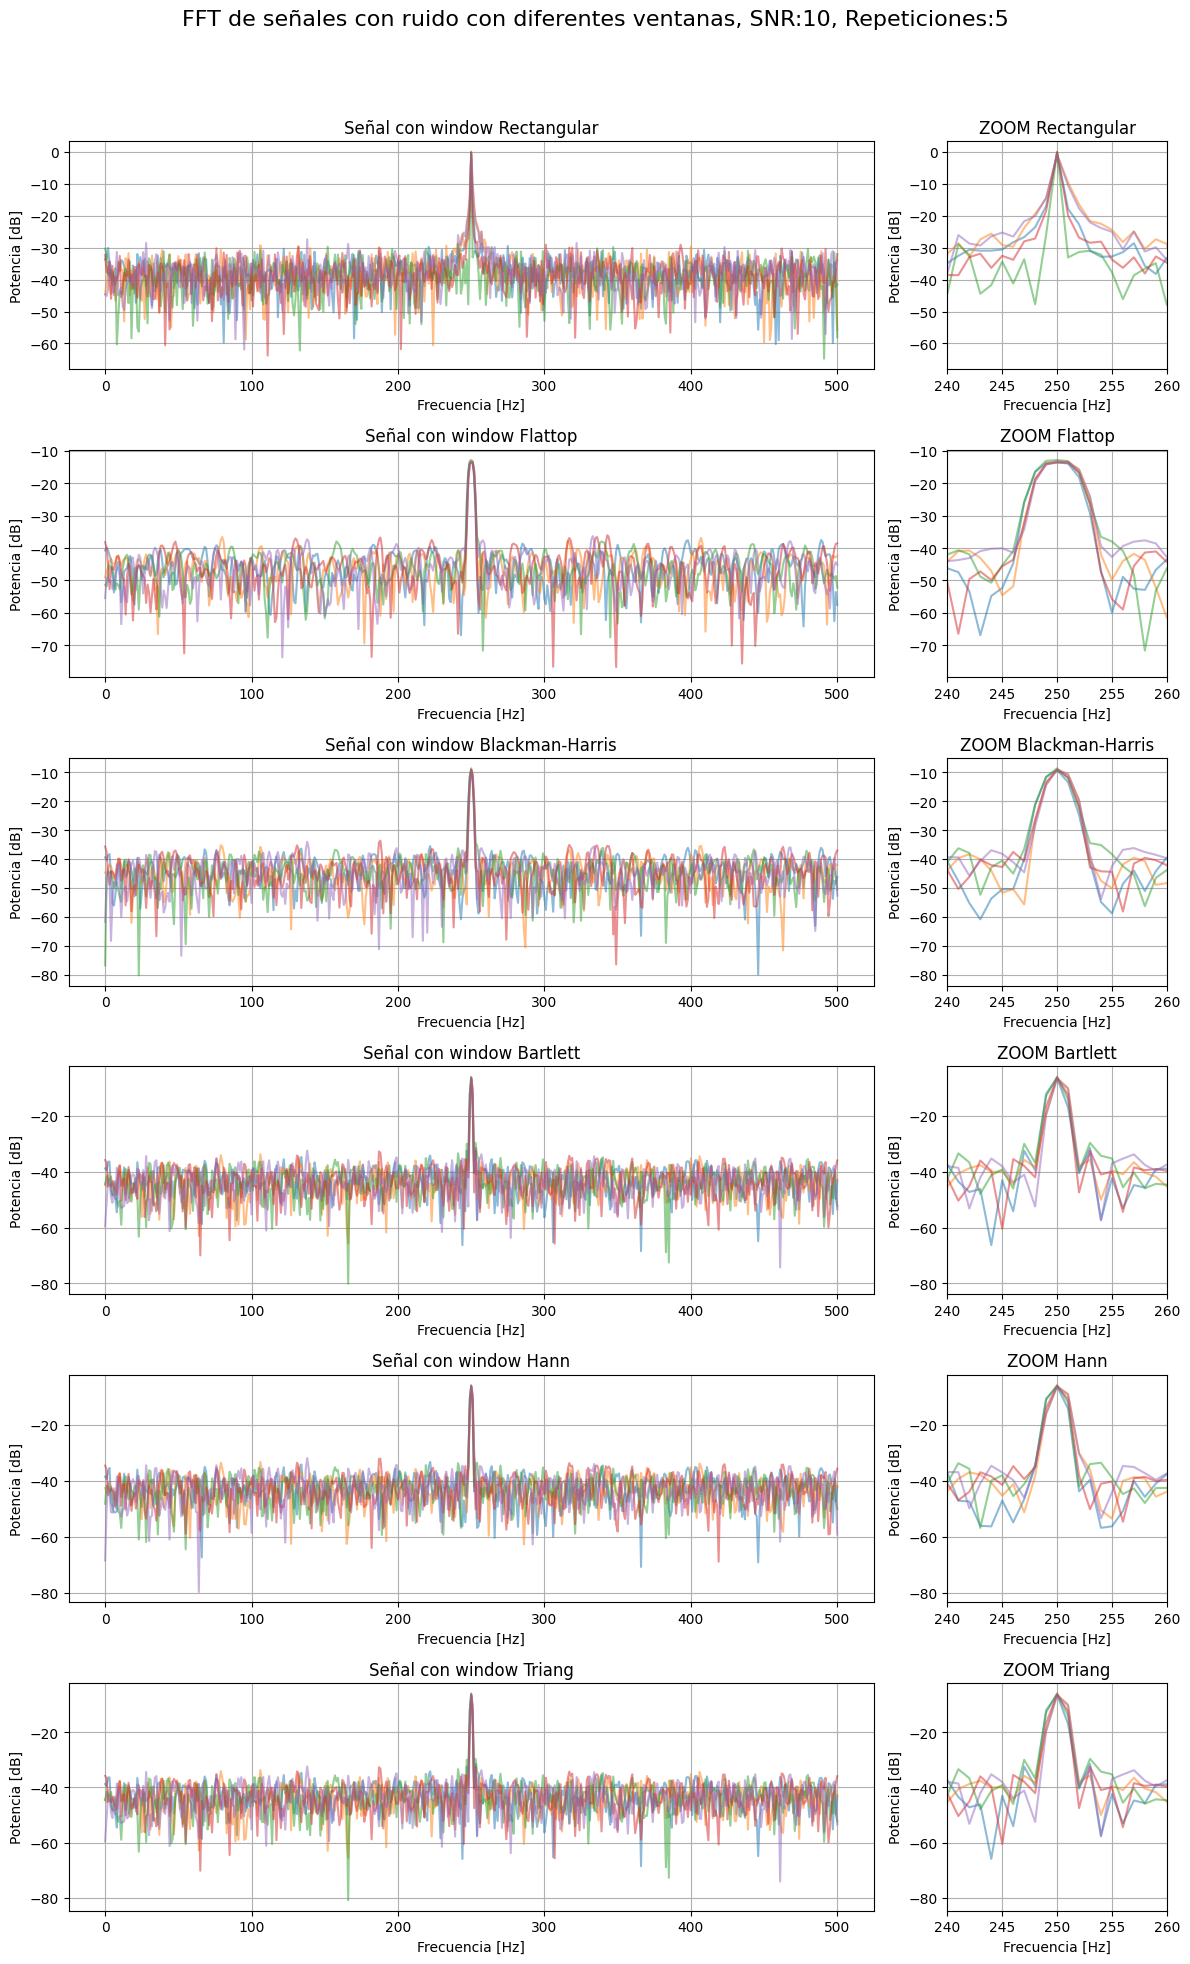

In [46]:
plt.figure(figsize=(12, 20))
repes =5

plt.subplot2grid((6, 4), (0, 0), colspan=3)
plot_freq(Xk_fft, ffx, repes, bfrec, 'Señal con window Rectangular', 'Frecuencia [Hz]', 'Potencia [dB]') 
plt.subplot2grid((6, 4), (0, 3))
plot_freq(Xk_fft, ffx, repes, bfrec, 'ZOOM Rectangular', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)

plt.subplot2grid((6, 4), (1, 0), colspan=3)
plot_freq(Xk_flattop_fft, ffx, repes, bfrec, 'Señal con window Flattop', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (1, 3))
plot_freq(Xk_flattop_fft, ffx, repes, bfrec, 'ZOOM Flattop', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)

plt.subplot2grid((6, 4), (2, 0), colspan=3)
plot_freq(Xk_blackh_fft, ffx, repes, bfrec, 'Señal con window Blackman-Harris', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (2, 3))
plot_freq(Xk_blackh_fft, ffx, repes, bfrec, 'ZOOM Blackman-Harris', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)

plt.subplot2grid((6, 4), (3, 0), colspan=3)
plot_freq(Xk_barlett_fft, ffx, repes, bfrec, 'Señal con window Bartlett', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (3, 3))
plot_freq(Xk_barlett_fft, ffx, repes, bfrec, 'ZOOM Bartlett', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)

plt.subplot2grid((6, 4), (4, 0), colspan=3)
plot_freq(Xk_han_fft, ffx, repes, bfrec, 'Señal con window Hann', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (4, 3))
plot_freq(Xk_han_fft, ffx, repes, bfrec, 'ZOOM Hann', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)

plt.subplot2grid((6, 4), (5, 0), colspan=3)
plot_freq(Xk_triang_fft, ffx, repes, bfrec, 'Señal con window Triang', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (5, 3))
plot_freq(Xk_triang_fft, ffx, repes, bfrec, 'ZOOM Triang', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)

plt.suptitle(f'FFT de señales con ruido con diferentes ventanas, SNR:{SNR}, Repeticiones:{repes}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#Ahora para SNR 3
plt.figure(figsize=(12, 20))
plt.subplot2grid((6, 4), (0, 0), colspan=3)
plot_freq(Xk_2_fft, ffx, repes, bfrec, 'Señal con window Rectangular', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (0, 3))
plot_freq(Xk_2_fft, ffx, repes, bfrec, 'ZOOM Rectangular', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.subplot2grid((6, 4), (1, 0), colspan=3)
plot_freq(Xk_flattop_2_fft, ffx, repes, bfrec, 'Señal con window Flattop', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (1, 3))
plot_freq(Xk_flattop_2_fft, ffx, repes, bfrec, 'ZOOM Flattop', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.subplot2grid((6, 4), (2, 0), colspan=3)
plot_freq(Xk_blackh_2_fft, ffx, repes, bfrec, 'Señal con window Blackman-Harris', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (2, 3))
plot_freq(Xk_blackh_2_fft, ffx, repes, bfrec, 'ZOOM Blackman-Harris', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.subplot2grid((6, 4), (3, 0), colspan=3)
plot_freq(Xk_barlett_2_fft, ffx, repes, bfrec, 'Señal con window Bartlett', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (3, 3))
plot_freq(Xk_barlett_2_fft, ffx, repes, bfrec, 'ZOOM Bartlett', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.subplot2grid((6, 4), (4, 0), colspan=3)
plot_freq(Xk_han_2_fft, ffx, repes, bfrec, 'Señal con window Hann', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (4, 3))
plot_freq(Xk_han_2_fft, ffx, repes, bfrec, 'ZOOM Hann', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.subplot2grid((6, 4), (5, 0), colspan=3)
plot_freq(Xk_triang_2_fft, ffx, repes, bfrec, 'Señal con window Triang', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.subplot2grid((6, 4), (5, 3))
plot_freq(Xk_triang_2_fft, ffx, repes, bfrec, 'ZOOM Triang', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.suptitle(f'FFT de señales con ruido con diferentes ventanas, SNR:{SNR_2}, Repeticiones:{repes}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

plt.figure(figsize=(12, 20))
plt.subplot(6,2,1)
plot_freq(Xk_fft, ffx, repes, bfrec, f'Rectangular, SNR:{SNR}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,2)
plot_freq(Xk_2_fft, ffx, repes, bfrec, f'Rectangular, SNR:{SNR_2}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,3)
plot_freq(Xk_flattop_fft, ffx, repes, bfrec, f'Flattop, SNR:{SNR}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,4)
plot_freq(Xk_flattop_2_fft, ffx, repes, bfrec, f'Flattop, SNR:{SNR_2}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,5)
plot_freq(Xk_blackh_fft, ffx, repes, bfrec, f'Blackman-Harris, SNR:{SNR}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,6)
plot_freq(Xk_blackh_2_fft, ffx, repes, bfrec, f'Blackman-Harris, SNR:{SNR_2}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,7)
plot_freq(Xk_barlett_fft, ffx, repes, bfrec, f'Barlett, SNR:{SNR}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,8)
plot_freq(Xk_barlett_2_fft, ffx, repes, bfrec, f'Barlett, SNR:{SNR_2}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,9)
plot_freq(Xk_han_fft, ffx, repes, bfrec, f'Hann, SNR:{SNR}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,10)
plot_freq(Xk_han_2_fft, ffx, repes, bfrec, f'Hann, SNR:{SNR_2}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,11)
plot_freq(Xk_triang_fft, ffx, repes, bfrec, f'Triang, SNR:{SNR}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.subplot(6,2,12)
plot_freq(Xk_triang_2_fft, ffx, repes, bfrec, f'Triang, SNR:{SNR_2}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(N/4 - 10, N/4 + 10)
plt.ylim(-80, 0)
plt.suptitle(f'FFT de señales con ruido con diferentes ventanas, Repeticiones:{repes}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Viendo los espectros sacos las siguientes conclusiones:

SNR = 10 VS. SNR = 3
La diferencia de ruido veo qque afecta en el piso de ruido. Se ve una diferencia entre el piso de ruido de los espectros con SNR = 3 (piso de ruido mayor) con los de SNR = 10. Mas alla de eso, en el pico de 250 no encuentro diferencias. Creo que cuando compre la estimacion de la amplitud y de la frecuecia entre los dos SNR no voy a encontrar grandes diferencias. 

Ventana Flattop:
Creo que el estimador de frecuencia que usa a la flattop como ventana va a tener una varianza super grande debido a que la funcion se comporta como una "meseta" en frecuencias cercanas a 250 HZ. 

Boxcar: 
Creo que el estimador de amplitud que usa a la Boxcar va a ser el que menor sesgo tenga. se ve que la funcion mas "picuda" que mas se acerca a cero. Sobre la varianza no puedo comentar mucho, para hacerlo, tendria que plotear las 200 realizaciones y poner el ylim super chico y ver. Para eso, prefiero hacer histogramas. 

## Estimador a

In [47]:
f0 = fs/4
a_implicita, a_implicita_media, a_implicita_var = estimador_a(Xk_fft, f0)
a_flattop, a_flattop_media, a_flattop_var = estimador_a(Xk_flattop_fft, f0)
a_blackh, a_blackh_media, a_blackh_var = estimador_a(Xk_blackh_fft, f0)
a_barlett, a_barlett_media, a_barlett_var = estimador_a(Xk_barlett_fft, f0)
a_han, a_han_media, a_han_var = estimador_a(Xk_han_fft, f0)
a_triang, a_triang_media, a_triang_var = estimador_a(Xk_triang_fft, f0)

a_2_implicita, a_2_implicita_media, a_2_implicita_var = estimador_a(Xk_2_fft, f0)
a_2_flattop, a_2_flattop_media, a_2_flattop_var = estimador_a(Xk_flattop_2_fft, f0)
a_2_blackh, a_2_blackh_media, a_2_blackh_var = estimador_a(Xk_blackh_2_fft, f0)
a_2_barlett, a_2_barlett_media, a_2_barlett_var = estimador_a(Xk_barlett_2_fft, f0)
a_2_han, a_2_han_media, a_2_han_var = estimador_a(Xk_han_2_fft, f0)
a_2_triang, a_2_triang_media, a_2_triang_var = estimador_a(Xk_triang_2_fft, f0)



Valor de a1 real:  1.4142135623730951


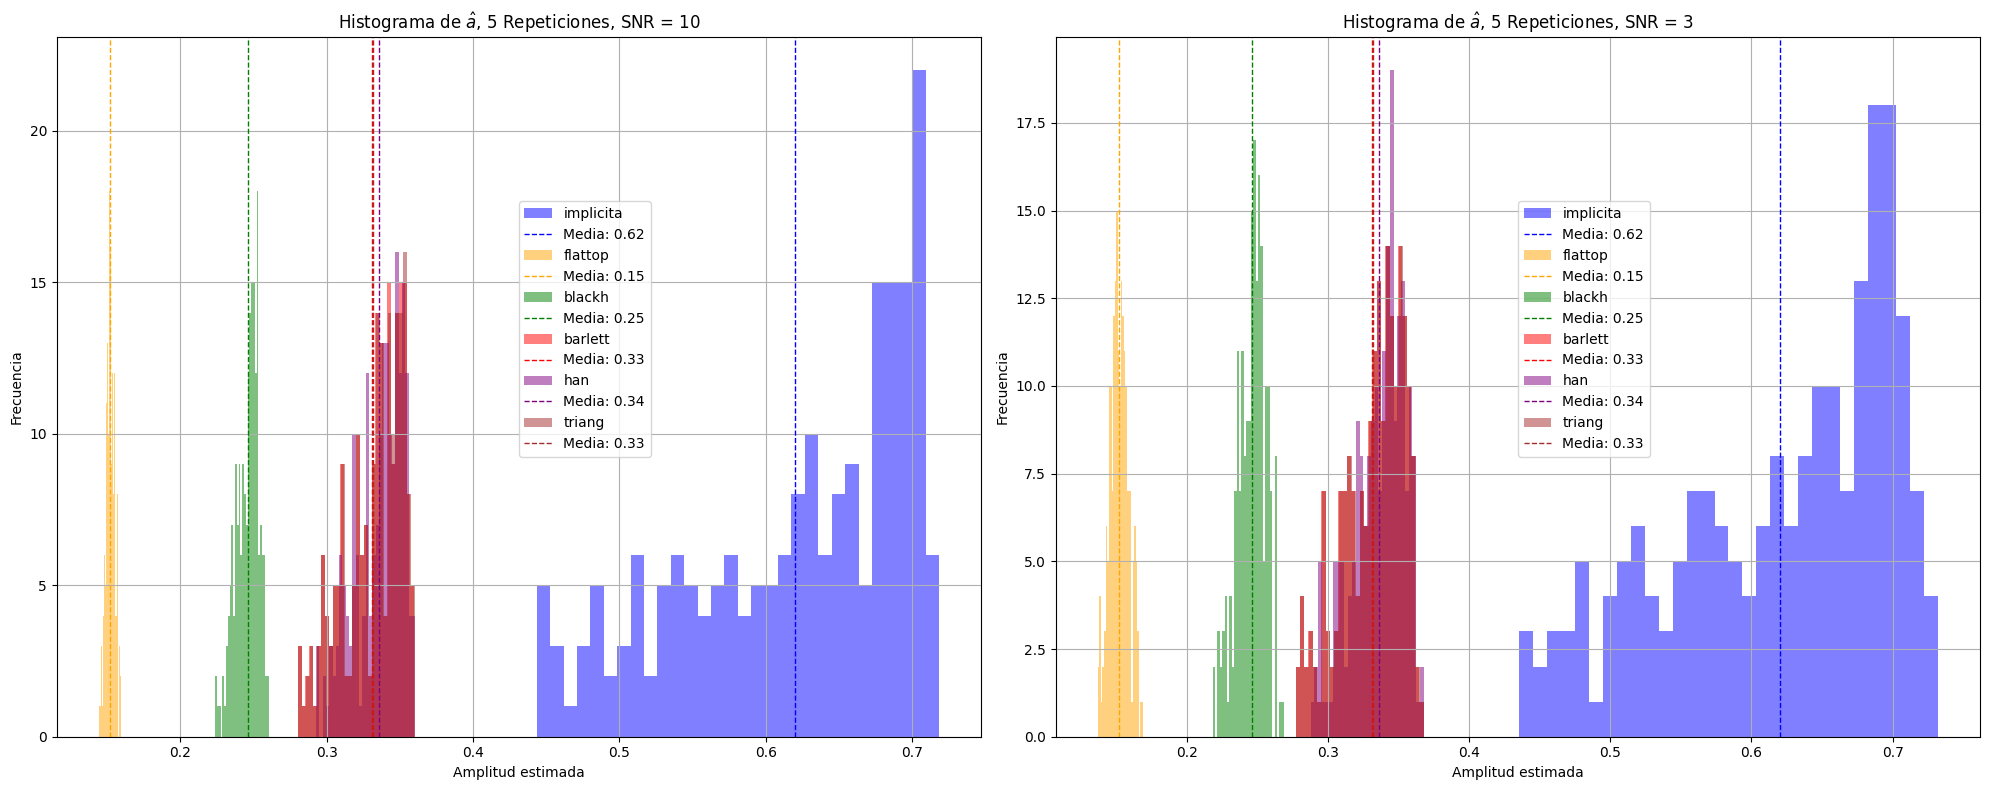

In [48]:

plt.figure(figsize=(20, 8))
plt.subplot(1,2,1)
plt.hist(a_implicita, color='blue', bins=30, alpha=0.5, label='implicita')
plt.axvline(a_implicita_media, color='blue', linestyle='dashed', linewidth=1, label=f'Media: {a_implicita_media:.2f}')
plt.hist(a_flattop, color='orange', bins=30, alpha=0.5, label='flattop')
plt.axvline(a_flattop_media, color='orange', linestyle='dashed', linewidth=1, label=f'Media: {a_flattop_media:.2f}')
plt.hist(a_blackh, color='green', bins=30, alpha=0.5, label='blackh')
plt.axvline(a_blackh_media, color='green', linestyle='dashed', linewidth=1, label=f'Media: {a_blackh_media:.2f}')
plt.hist(a_barlett, color='red', bins=30, alpha=0.5, label='barlett')
plt.axvline(a_barlett_media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {a_barlett_media:.2f}')
plt.hist(a_han, color='purple', bins=30, alpha=0.5, label='han')
plt.axvline(a_han_media, color='purple', linestyle='dashed', linewidth=1, label=f'Media: {a_han_media:.2f}')
plt.hist(a_triang, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(a_triang_media, color='brown', linestyle='dashed', linewidth=1, label=f'Media: {a_triang_media:.2f}')
plt.title(f'Histograma de $\\hat{{a}}$, {repes} Repeticiones, SNR = {SNR}')
plt.xlabel("Amplitud estimada")
plt.ylabel("Frecuencia")
plt.legend(loc=(0.5, 0.4))
plt.grid()

plt.subplot(1,2,2)
plt.hist(a_2_implicita, color='blue', bins=30, alpha=0.5, label='implicita')
plt.axvline(a_2_implicita_media, color='blue', linestyle='dashed', linewidth=1, label=f'Media: {a_2_implicita_media:.2f}')
plt.hist(a_2_flattop, color='orange', bins=30, alpha=0.5, label='flattop')
plt.axvline(a_2_flattop_media, color='orange', linestyle='dashed', linewidth=1, label=f'Media: {a_2_flattop_media:.2f}')
plt.hist(a_2_blackh, color='green', bins=30, alpha=0.5, label='blackh')
plt.axvline(a_2_blackh_media, color='green', linestyle='dashed', linewidth=1, label=f'Media: {a_2_blackh_media:.2f}')
plt.hist(a_2_barlett, color='red', bins=30, alpha=0.5, label='barlett')
plt.axvline(a_2_barlett_media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {a_2_barlett_media:.2f}')
plt.hist(a_2_han, color='purple', bins=30, alpha=0.5, label='han')
plt.axvline(a_2_han_media, color='purple', linestyle='dashed', linewidth=1, label=f'Media: {a_2_han_media:.2f}')
plt.hist(a_2_triang, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(a_2_triang_media, color='brown', linestyle='dashed', linewidth=1, label=f'Media: {a_2_triang_media:.2f}')
plt.title(f'Histograma de $\\hat{{a}}$, {repes} Repeticiones, SNR = {SNR_2}')
plt.xlabel("Amplitud estimada")
plt.ylabel("Frecuencia")
plt.legend(loc=(0.5, 0.4))
plt.grid()


plt.tight_layout()
print('Valor de a1 real: ', a1)
plt.show()


No se observan diferencias entre entre $ SNR = 10 $ y $ SNR = 3 $. 

En cuento a sesgo, los 6 estimadores tienen sesgo. La boxcar es el que menos tiene, y la flattop es la que mas. Boxcar, sin embargo, es la que mas varinza presenta. a ojo, veo que flattop es la que menos varianza presenta. 

Si tengo que elejir un estimador, voy a elejir al que menos varianza tenga. Ya que el sesgo se puede insesgar. 

A continuacion muestro como insesgo a los estimadores...


In [49]:
sesgo_implicita = a_implicita_media - a1
sesgo_flattop = a_flattop_media - a1
sesgo_blackh = a_blackh_media - a1
sesgo_barlett = a_barlett_media - a1
sesgo_han = a_han_media - a1
sesgo_triang = a_triang_media - a1

sesgo_2_implicita = a_2_implicita_media - a1
sesgo_2_flattop = a_2_flattop_media - a1
sesgo_2_blackh = a_2_blackh_media - a1
sesgo_2_barlett = a_2_barlett_media - a1
sesgo_2_han = a_2_han_media - a1
sesgo_2_triang = a_2_triang_media - a1

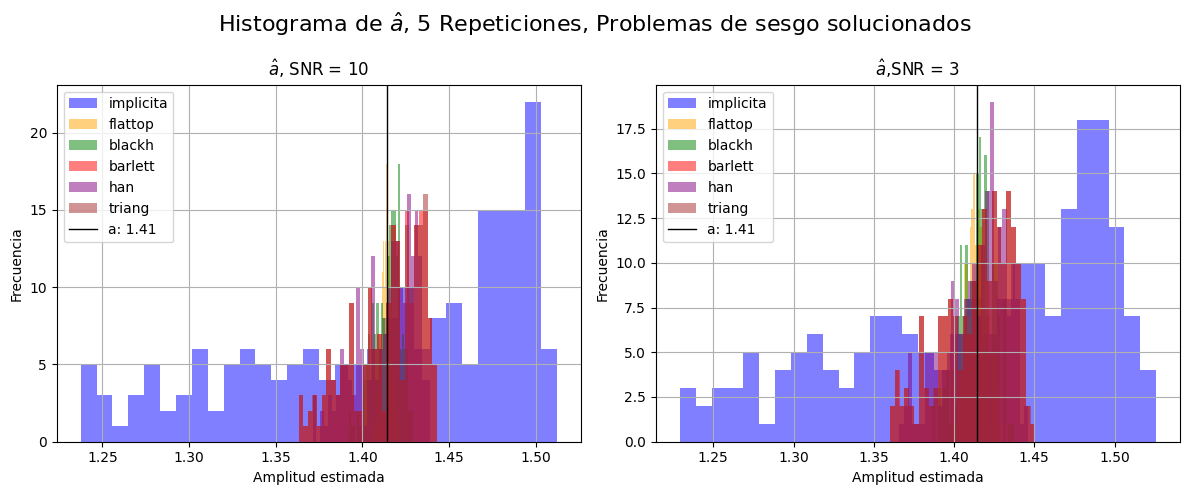

In [50]:
a_implicita_c = a_implicita - sesgo_implicita
a_flattop_c = a_flattop - sesgo_flattop
a_blackh_c = a_blackh - sesgo_blackh
a_barlett_c = a_barlett - sesgo_barlett
a_han_c = a_han - sesgo_han
a_triang_c = a_triang - sesgo_triang

a_2_implicita_c = a_2_implicita - sesgo_2_implicita
a_2_flattop_c = a_2_flattop - sesgo_2_flattop
a_2_blackh_c = a_2_blackh - sesgo_2_blackh
a_2_barlett_c = a_2_barlett - sesgo_2_barlett
a_2_han_c = a_2_han - sesgo_2_han
a_2_triang_c = a_2_triang - sesgo_2_triang


plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(a_implicita_c,color = 'blue', bins=30, alpha=0.5, label='implicita')
plt.hist(a_flattop_c, color='orange', bins=30, alpha=0.5, label='flattop')
plt.hist(a_blackh_c, color='green', bins=30, alpha=0.5, label='blackh')
plt.hist(a_barlett_c, color='red', bins=30, alpha=0.5, label='barlett')
plt.hist(a_han_c, color='purple', bins=30, alpha=0.5, label='han')
plt.hist(a_triang_c, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(a1, color='black', linestyle='-', linewidth=1, label=f'a: {a1:.2f}')
plt.title(f'$\\hat{{a}}$, SNR = {SNR} ')
plt.xlabel("Amplitud estimada")
plt.grid()
plt.ylabel("Frecuencia")
plt.legend()

plt.subplot(1,2,2)
plt.hist(a_2_implicita_c, color='blue', bins=30, alpha=0.5, label='implicita')
plt.hist(a_2_flattop_c, color='orange', bins=30, alpha=0.5, label='flattop')
plt.hist(a_2_blackh_c, color='green', bins=30, alpha=0.5, label='blackh')
plt.hist(a_2_barlett_c, color='red', bins=30, alpha=0.5, label='barlett')
plt.hist(a_2_han_c, color='purple', bins=30, alpha=0.5, label='han')
plt.hist(a_2_triang_c, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(a1, color='black', linestyle='-', linewidth=1, label=f'a: {a1:.2f}')
plt.title(f'$\\hat{{a}}$,SNR = {SNR_2} ')
plt.xlabel("Amplitud estimada")
plt.ylabel("Frecuencia")
plt.grid()
plt.legend()
plt.suptitle(f'Histograma de $\\hat{{a}}$, {repes} Repeticiones, Problemas de sesgo solucionados', fontsize=16)
plt.tight_layout()

plt.show()


In [51]:
plt.figure(figsize=(8, 6))
a_ventanas = [a_implicita_media, a_flattop_media, a_blackh_media, a_barlett_media, a_han_media, a_triang_media]
a_2_ventanas = [a_2_implicita_media, a_2_flattop_media, a_2_blackh_media, a_2_barlett_media, a_2_han_media, a_2_triang_media]   
a_sesgos = [sesgo_implicita, sesgo_flattop, sesgo_blackh, sesgo_barlett, sesgo_han, sesgo_triang]
a_2_sesgos = [sesgo_2_implicita, sesgo_2_flattop, sesgo_2_blackh, sesgo_2_barlett, sesgo_2_han, sesgo_2_triang]
a_varianzas = [a_implicita_var, a_flattop_var, a_blackh_var, a_barlett_var, a_han_var, a_triang_var]
a_2_varianzas = [a_2_implicita_var, a_2_flattop_var, a_2_blackh_var, a_2_barlett_var, a_2_han_var, a_2_triang_var]
plt.subplot(1,2,1)
labels = ['Implicita', 'Flattop', 'Blackman-Harris', 'Barlett', 'Hann', 'Triang']
plt.scatter(range(len(a_varianzas)), a_varianzas, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xticks(range(len(a_varianzas)), labels, rotation=45, fontsize=10)
plt.title(f'SNR:{SNR}', fontsize=14)
plt.ylabel('Varianza', fontsize=12)
plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(range(len(a_2_varianzas)), a_2_varianzas, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xticks(range(len(a_2_varianzas)), labels, rotation=45, fontsize=10)
plt.title(f'SNR:{SNR_2}', fontsize=14)
plt.ylabel('Varianza', fontsize=12)
plt.grid(True)
plt.suptitle('Varianza de los estimadores de a', fontsize=16)
plt.tight_layout()
plt.show()


### Conclusiones
En ambos casos el estimador de mejor sesgo (osea menor sesgo) fue la rectangular. Sin embargo, es el de mayor mayor varianza. Como bien mostre. el problema de sesgo tiene solucion. Mientras que la varianza no. 
Se observa como la flattop y Blackman-Harris tiene menor varianza. 

## Estimador w

In [52]:
w_implicita, w_implicita_media, w_implicita_var = estimador_w(Xk_fft, bfrec, df)
w_flattop, w_flattop_media, w_flattop_var = estimador_w(Xk_flattop_fft, bfrec, df)
w_blackh, w_blackh_media, w_blackh_var = estimador_w(Xk_blackh_fft, bfrec, df)
w_barlett, w_barlett_media, w_barlett_var = estimador_w(Xk_barlett_fft, bfrec, df)
w_han, w_han_media, w_han_var = estimador_w(Xk_han_fft, bfrec, df)
w_triang, w_triang_media, w_triang_var = estimador_w(Xk_triang_fft, bfrec, df)

w_2_implicita, w_2_implicita_media, w_2_implicita_var = estimador_w(Xk_2_fft, bfrec, df)
w_2_flattop, w_2_flattop_media, w_2_flattop_var = estimador_w(Xk_flattop_2_fft, bfrec, df)
w_2_blackh, w_2_blackh_media, w_2_blackh_var = estimador_w(Xk_blackh_2_fft, bfrec, df)
w_2_barlett, w_2_barlett_media, w_2_barlett_var = estimador_w(Xk_barlett_2_fft, bfrec, df)
w_2_han, w_2_han_media, w_2_han_var = estimador_w(Xk_han_2_fft, bfrec, df)
w_2_triang, w_2_triang_media, w_2_triang_var = estimador_w(Xk_triang_2_fft, bfrec, df)

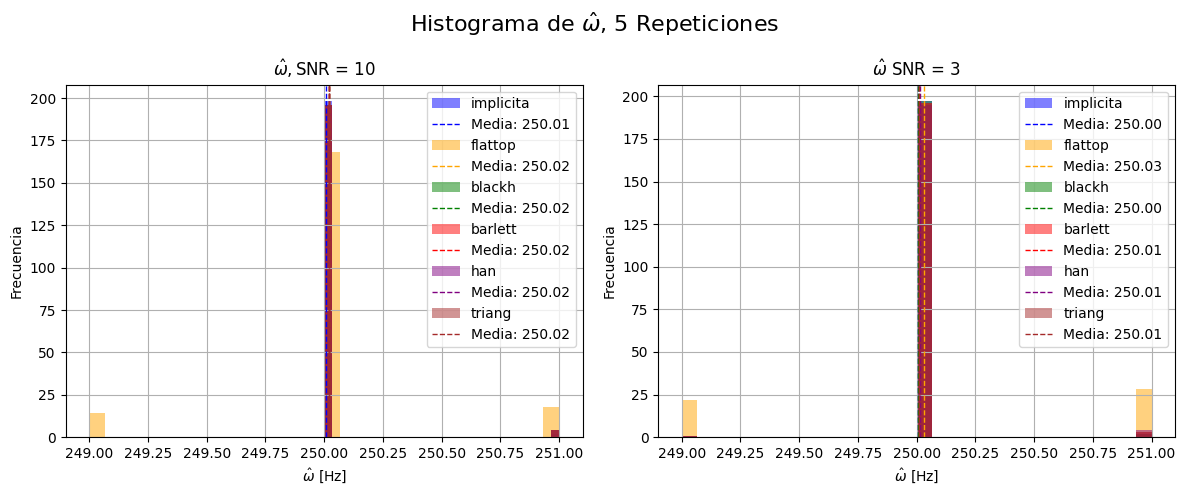

In [53]:
plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(w_implicita,color = 'blue', bins=30, alpha=0.5, label='implicita')
plt.axvline(w_implicita_media, color='blue', linestyle='dashed', linewidth=1, label=f'Media: {w_implicita_media:.2f}')
plt.hist(w_flattop, color='orange', bins=30, alpha=0.5, label='flattop')
plt.axvline(w_flattop_media, color='orange', linestyle='dashed', linewidth=1, label=f'Media: {w_flattop_media:.2f}')
plt.hist(w_blackh, color='green', bins=30, alpha=0.5, label='blackh')
plt.axvline(w_blackh_media, color='green', linestyle='dashed', linewidth=1, label=f'Media: {w_blackh_media:.2f}')
plt.hist(w_barlett, color='red', bins=30, alpha=0.5, label='barlett')
plt.axvline(w_barlett_media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {w_barlett_media:.2f}')
plt.hist(w_han, color='purple', bins=30, alpha=0.5, label='han')
plt.axvline(w_han_media, color='purple', linestyle='dashed', linewidth=1, label=f'Media: {w_han_media:.2f}')
plt.hist(w_triang, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(w_triang_media, color='brown', linestyle='dashed', linewidth=1, label=f'Media: {w_triang_media:.2f}')
plt.legend()
plt.xlabel("$\\hat{{\omega}}$ [Hz]")
plt.ylabel("Frecuencia")
plt.title(f'$\\hat{{\omega}}, $SNR = {SNR}')
plt.grid()

plt.subplot(1,2,2)
plt.hist(w_2_implicita, color='blue', bins=30, alpha=0.5, label='implicita')
plt.axvline(w_2_implicita_media, color='blue', linestyle='dashed', linewidth=1, label=f'Media: {w_2_implicita_media:.2f}')
plt.hist(w_2_flattop, color='orange', bins=30, alpha=0.5, label='flattop')
plt.axvline(w_2_flattop_media, color='orange', linestyle='dashed', linewidth=1, label=f'Media: {w_2_flattop_media:.2f}')
plt.hist(w_2_blackh, color='green', bins=30, alpha=0.5, label='blackh')
plt.axvline(w_2_blackh_media, color='green', linestyle='dashed', linewidth=1, label=f'Media: {w_2_blackh_media:.2f}')
plt.hist(w_2_barlett, color='red', bins=30, alpha=0.5, label='barlett')
plt.axvline(w_2_barlett_media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {w_2_barlett_media:.2f}')
plt.hist(w_2_han, color='purple', bins=30, alpha=0.5, label='han')
plt.axvline(w_2_han_media, color='purple', linestyle='dashed', linewidth=1, label=f'Media: {w_2_han_media:.2f}')
plt.hist(w_2_triang, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(w_2_triang_media, color='brown', linestyle='dashed', linewidth=1, label=f'Media: {w_2_triang_media:.2f}')
plt.legend()
plt.xlabel("$\\hat{{\omega}}$ [Hz]")
plt.ylabel("Frecuencia")
plt.title(f'$\\hat{{\omega}}$ SNR = {SNR_2}')
plt.grid()
plt.suptitle(f'Histograma de $\\hat{{\omega}}$, {repes} Repeticiones', fontsize=16)
plt.tight_layout()
plt.show()

Observando el grafico, no me parece muy buena decision elejir un estimador bajo estas circunstancias. La resolucion espectral que tengo no me permite hacer un buen analisis. En el Bonus hago Zero- Padding

In [54]:
plt.figure(figsize=(8, 6))
plt.hist(np.ravel(ff),color = 'black', bins=30, alpha=0.5, label='frecuencia real')
plt.axvline(ff.mean(), color='black', linestyle='dashed', linewidth=1, label=f'Media: {ff.mean():.2f}')
plt.xlabel("$\omega$ [Hz]")
plt.ylabel("Frecuencia")
plt.title(f'Histograma de Frec real, {repes} Repeticiones, SNR = {SNR}')
plt.grid()
plt.legend()
plt.show()

De la consigna interpreto que la frecuencia que quiero estimar es la que tiene sumada el ruido. No la constante. Por lo tanto tengo un vector de "Valores reales de frecuencia", decidi calcularle la media y trabajar a este valor como el "Valor real" a apartir del cual voy a calcular los sesgos. 

In [55]:
sesgo_w_implicita = w_implicita_media - ff.mean()
sesgo_w_flattop = w_flattop_media - ff.mean()
sesgo_w_blackh = w_blackh_media - ff.mean()
sesgo_w_barlett = w_barlett_media - ff.mean()
sesgo_w_han = w_han_media - ff.mean()
sesgo_w_triang = w_triang_media - ff.mean()

sesgo_2_w_implicita = w_2_implicita_media - ff.mean()
sesgo_2_w_flattop = w_2_flattop_media - ff.mean()
sesgo_2_w_blackh = w_2_blackh_media - ff.mean()
sesgo_2_w_barlett = w_2_barlett_media - ff.mean()
sesgo_2_w_han = w_2_han_media - ff.mean()
sesgo_2_w_triang = w_2_triang_media - ff.mean()


In [56]:
plt.figure(figsize=(8, 6))
w_ventanas = [w_implicita_media, w_flattop_media, w_blackh_media, w_barlett_media, w_han_media, w_triang_media]
w_2_ventanas = [w_2_implicita_media, w_2_flattop_media, w_2_blackh_media, w_2_barlett_media, w_2_han_media, w_2_triang_media]
w_sesgos = [sesgo_w_implicita, sesgo_w_flattop, sesgo_w_blackh, sesgo_w_barlett, sesgo_w_han, sesgo_w_triang]
w_2_sesgos = [sesgo_2_w_implicita, sesgo_2_w_flattop, sesgo_2_w_blackh, sesgo_2_w_barlett, sesgo_2_w_han, sesgo_2_w_triang]
w_varianzas = [w_implicita_var, w_flattop_var, w_blackh_var, w_barlett_var, w_han_var, w_triang_var]
w_2_varianzas = [w_2_implicita_var, w_2_flattop_var, w_2_blackh_var, w_2_barlett_var, w_2_han_var, w_2_triang_var]
plt.subplot(1,2,1)
labels = ['Rectangular', 'Flattop', 'Blackman-Harris', 'Barlett', 'Hann', 'Triang']
plt.scatter(range(len(w_varianzas)), w_varianzas, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xticks(range(len(w_varianzas)), labels, rotation=45, fontsize=10)
plt.title(f'Varianza  $\\hat{{\omega}}$, SNR: {SNR}', fontsize=14)
plt.ylabel('Varianza', fontsize=12)
plt.grid(True)

plt.subplot(1,2,2)
plt.scatter(range(len(w_2_varianzas)), w_2_varianzas, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xticks(range(len(w_2_varianzas)), labels, rotation=45, fontsize=10)
plt.title(f'Varianza $\\hat{{\omega}}$, SNR:{SNR_2}', fontsize=14)
plt.ylabel('Varianza', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.plot()

[]

In [57]:
from prettytable import PrettyTable
table = PrettyTable()
table.field_names = ['Window', 'â', 'â - a', 'Var(â)', 'ω̂', 'ω̂ - ω', 'Var(ω̂)']

for i in range(len(labels)):
    table.add_row([
    labels[i], 
    f"{a_ventanas[i]:.3f}", 
    f"{a_sesgos[i]:.3f}", 
    f"{a_varianzas[i]:.5f}", 
    f"{w_ventanas[i]:.3f}", 
    f"{w_sesgos[i]:.3f}", 
    f"{w_varianzas[i]:.5f}"
])
print(f'-----------------------------------')
print(f'-----------   RESUMEN   -----------')
print(f'-----------------------------------')

print(f'SNR: {SNR}')
print(f'a real: {a1:.3f}')
print(f'ω real:{ff.mean():.2f}')
print(table)

table_2 = PrettyTable()
table_2.field_names = ['Window', 'â', 'â - a', 'Var(â)', 'ω̂', 'ω̂ - ω', 'Var(ω̂)']
for i in range(len(labels)):
    table_2.add_row([
    labels[i], 
    f"{a_2_ventanas[i]:.3f}", 
    f"{a_2_sesgos[i]:.3f}", 
    f"{a_2_varianzas[i]:.5f}", 
    f"{w_2_ventanas[i]:.3f}", 
    f"{w_2_sesgos[i]:.3f}", 
    f"{w_2_varianzas[i]:.5f}"
])
print(f'SNR: {SNR_2}')
print(f'a real: {a1:.3f}')
print(f'ω real:{ff.mean():.2f}')
print(table_2)

-----------------------------------
-----------   RESUMEN   -----------
-----------------------------------
SNR: 10
a real: 1.414
ω real:250.03
+-----------------+-------+--------+---------+---------+--------+---------+
|      Window     |   â   | â - a  |  Var(â) |    ω̂    | ω̂ - ω  |  Var(ω̂) |
+-----------------+-------+--------+---------+---------+--------+---------+
|   Rectangular   | 0.620 | -0.794 | 0.00583 | 250.010 | -0.024 | 0.00990 |
|     Flattop     | 0.152 | -1.262 | 0.00001 | 250.020 | -0.014 | 0.15960 |
| Blackman-Harris | 0.246 | -1.168 | 0.00006 | 250.020 | -0.014 | 0.01960 |
|     Barlett     | 0.331 | -1.083 | 0.00040 | 250.020 | -0.014 | 0.01960 |
|       Hann      | 0.336 | -1.079 | 0.00026 | 250.020 | -0.014 | 0.01960 |
|      Triang     | 0.331 | -1.083 | 0.00040 | 250.020 | -0.014 | 0.01960 |
+-----------------+-------+--------+---------+---------+--------+---------+
SNR: 3
a real: 1.414
ω real:250.03
+-----------------+-------+--------+---------+---------+--

Si bien la implicita es la que presenta una menor varianza, no es conveniente estimar la frecuencia cuando tengo una resolucion espectral mala. Voy a mejorar la resolucion espectral (haciendo cero-padding). 

## Zero - Padding ¿Para que sirve?

Ventajas: 
- la FFT genera mas puntos entre las frecuencias originales lo que suaviza el espectro (El cero-padding equivale a convolucionar el espectro original con una sinc. Esto genera una curva suave entre los bins originales.)
- Los ceros no agregan informacion nueva, solo permiten distinguir componentes cercanos en frecuencia

A continuacion muestro el espectro luego de hacer zero - padding. Los graficos que vienen a continuacion los hice para ver como interpola la sinc y como se ve para distintas versiones. Le hice zero - padding a la señal convolucionada con la boxcar (implicita)

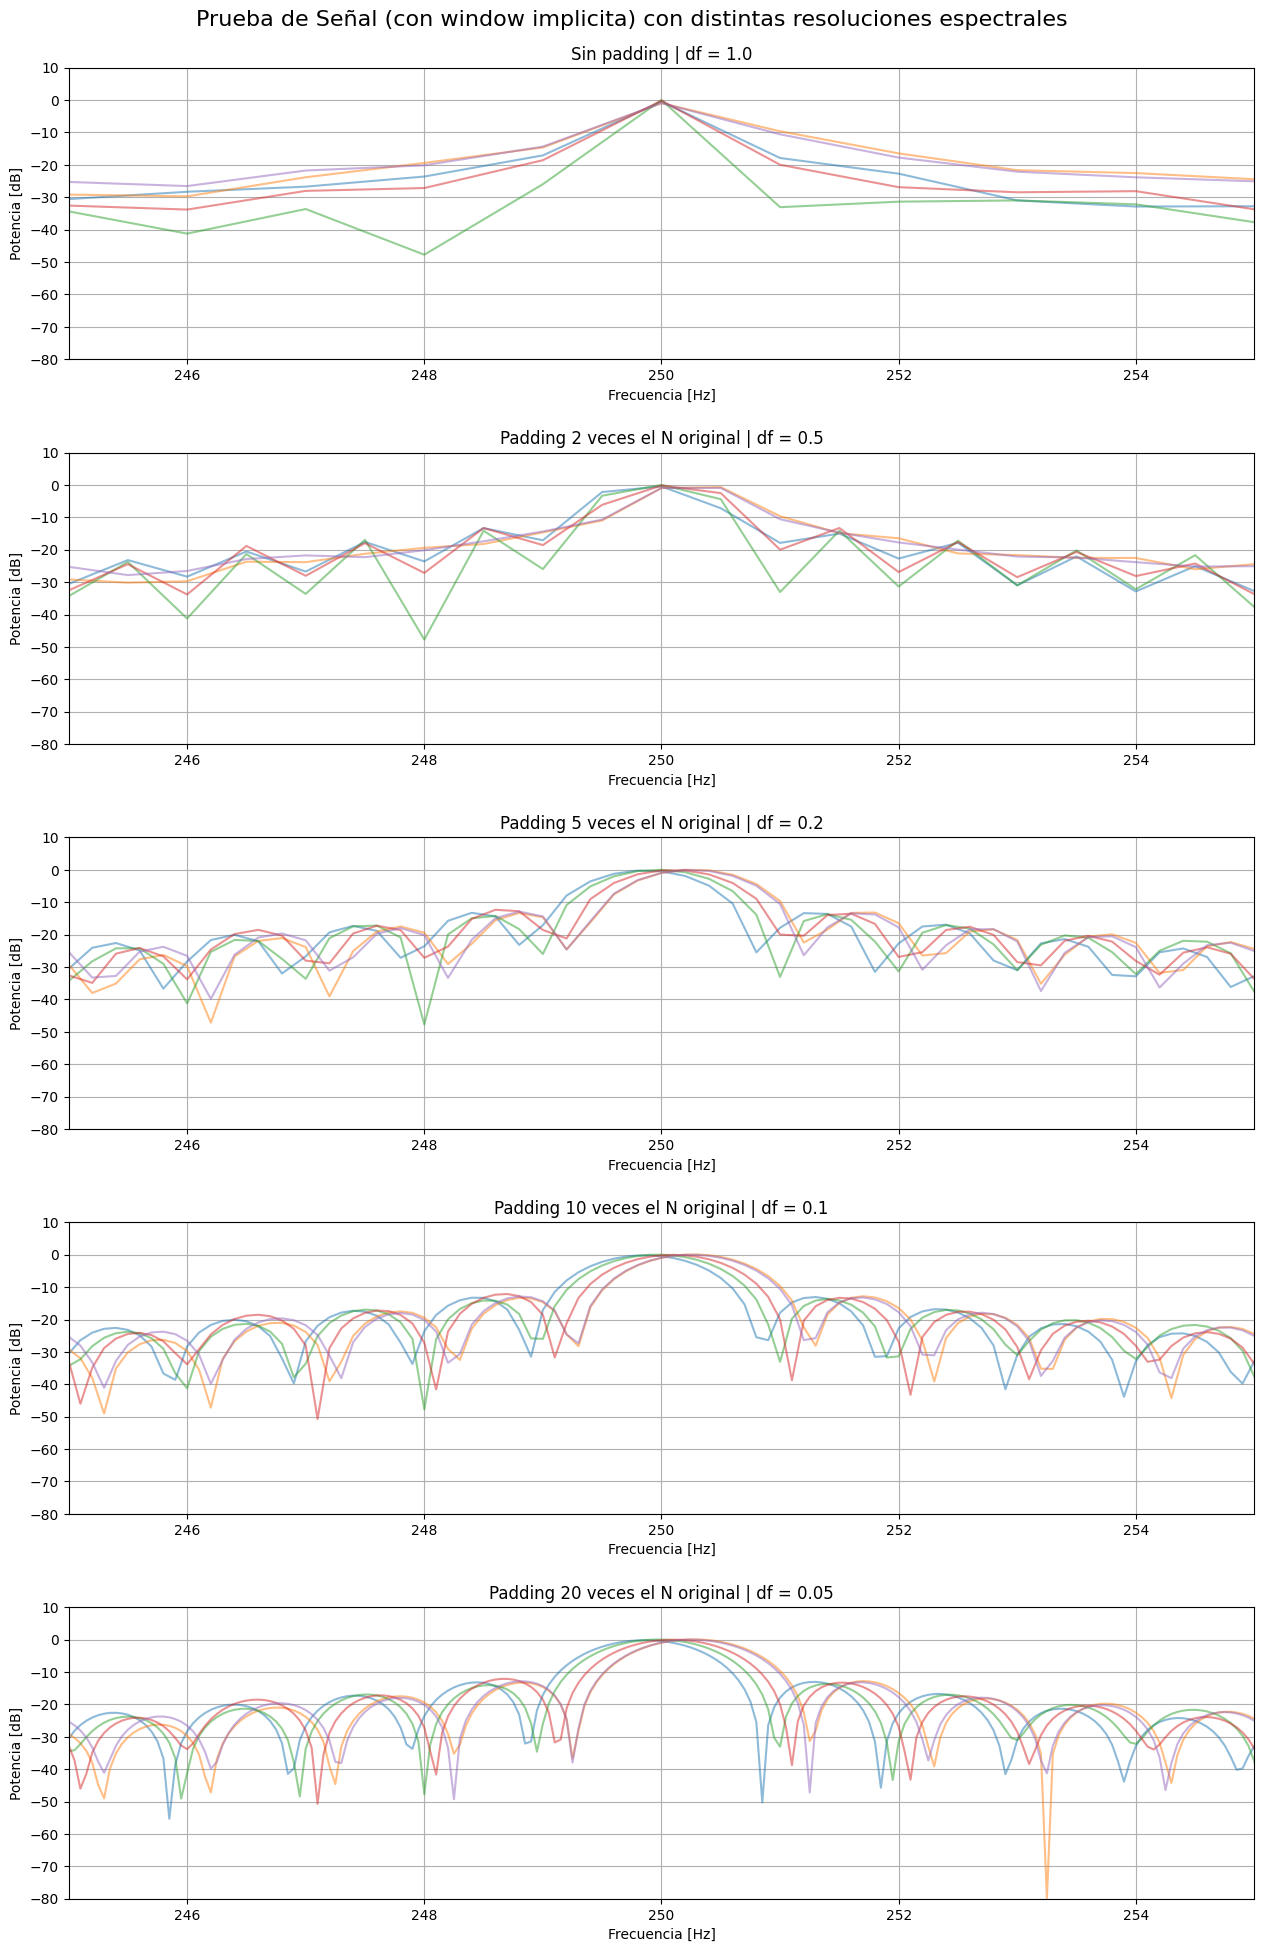

In [ ]:
N_pad_1 = N * 2
N_pad_2 = N * 5
N_pad_3 = N * 10
N_pad_4 = N * 20

Xk_fft_pad, ffx_pad, bfrec_pad, df_pad = gen_fft(xk,fs=fs, cte=N_pad_1)
Xk_fft_pad_2, ffx_pad_2, bfrec_pad_2, df_pad_2 = gen_fft(xk,fs=fs, cte=N_pad_2)
Xk_fft_pad_3, ffx_pad_3, bfrec_pad_3, df_pad_3 = gen_fft(xk,fs=fs, cte=N_pad_3)
Xk_fft_pad_4, ffx_pad_4, bfrec_pad_4, df_pad_4 = gen_fft(xk,fs=fs, cte=N_pad_4)

plt.figure(figsize=(13, 20))
plt.subplot(5,1,1) #sin padding
plot_freq(Xk_fft, ffx, repes, bfrec, f'Sin padding | df = {df}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(fs/4 - 5, fs/4 + 5)
plt.ylim(-80, 10)
plt.subplot(5,1,2) 
plot_freq(Xk_fft_pad, ffx_pad, repes, bfrec_pad, f'Padding 2 veces el N original | df = {df_pad}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(fs/4 - 5, fs/4 + 5)
plt.ylim(-80, 10)
plt.subplot(5,1,3) 
plot_freq(Xk_fft_pad_2, ffx_pad_2, repes, bfrec_pad_2, f'Padding 5 veces el N original | df = {df_pad_2}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(fs/4 - 5, fs/4 + 5)
plt.ylim(-80, 10)
plt.subplot(5,1,4) 
plot_freq(Xk_fft_pad_3, ffx_pad_3, repes, bfrec_pad_3, f'Padding 10 veces el N original | df = {df_pad_3}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(fs/4 - 5, fs/4 + 5)
plt.ylim(-80, 10)
plt.subplot(5,1,5)
plot_freq(Xk_fft_pad_4, ffx_pad_4, repes, bfrec_pad_4, f'Padding 20 veces el N original | df = {df_pad_4}', 'Frecuencia [Hz]', 'Potencia [dB]')
plt.xlim(fs/4 - 5, fs/4 + 5)
plt.ylim(-80, 10)

plt.suptitle('Prueba de Señal (con window implicita) con distintas resoluciones espectrales', fontsize=16)
plt.tight_layout( pad=2.0)
plt.show()



Se ve re bien como al pasar de df=1 a df=0.5 ahora 2 bins cada 1 "antiguo" bin. Antes de 250 a 252 tenia 3 bins. ahora tengo 5. (incluyendo bordes)

Me voy a quedar con el padding tal que ahora tengo 20*N puntos. Osea que paso de tener N=1000 muestras de cada señal, relleno con ceros tal que obtengo 10*N 

Ahora voy a Analizar el efecto del zero-padding para el estimador  Ω^1. Voy a hcer zero-padding a las 6 ventanas tanto para SNR = 10 como para SNR = 2

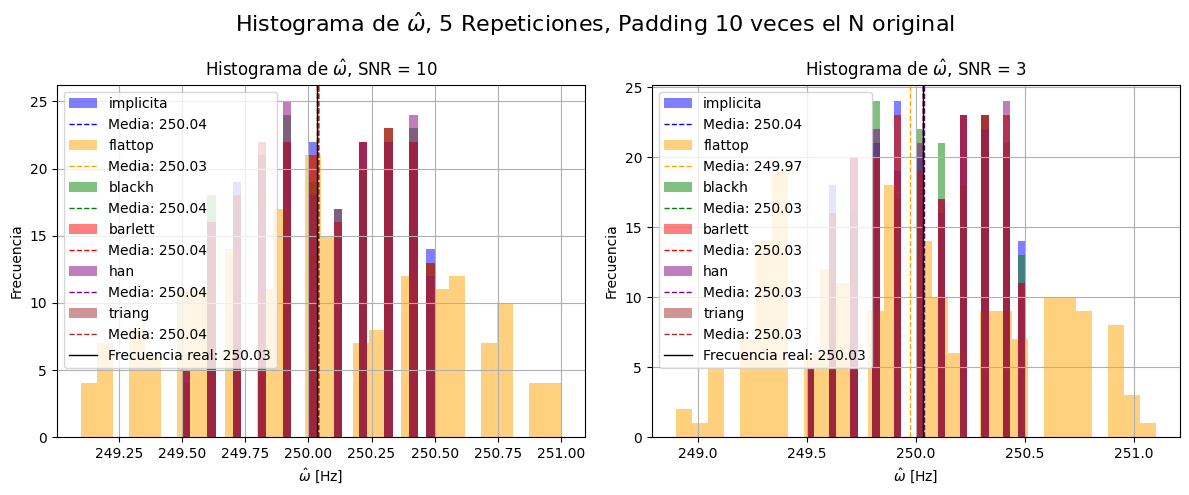

In [59]:

Xk_fft_pad_implicita, ffx_pad, bfrec_pad, df_pad = gen_fft(xk,fs=fs, cte=N_pad_3)
Xk_flattop_fft_pad, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_flattop,fs=fs, cte=N_pad_3)
Xk_blackh_fft_pad, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_blackh,fs=fs, cte=N_pad_3)
Xk_barlett_fft_pad, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_barlett,fs=fs, cte=N_pad_3)
Xk_han_fft_pad, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_han,fs=fs, cte=N_pad_3)
Xk_triang_fft_pad, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_triang,fs=fs, cte=N_pad_3)


Xk_fft_pad_implicita_2, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_2,fs=fs, cte=N_pad_3)
Xk_flattop_fft_pad_2, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_flattop_2,fs=fs, cte=N_pad_3)
Xk_blackh_fft_pad_2, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_blackh_2,fs=fs, cte=N_pad_3)
Xk_barlett_fft_pad_2, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_barlett_2,fs=fs, cte=N_pad_3)
Xk_han_fft_pad_2, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_han_2,fs=fs, cte=N_pad_3)
Xk_triang_fft_pad_2, ffx_pad, bfrec_pad, df_pad = gen_fft(xk_triang_2,fs=fs, cte=N_pad_3)



w_implicita_pad, w_implicita_pad_media, w_implicita_pad_var = estimador_w(Xk_fft_pad_implicita, bfrec_pad, df_pad)
w_flattop_pad, w_flattop_pad_media, w_flattop_pad_var = estimador_w(Xk_flattop_fft_pad, bfrec_pad, df_pad)
w_blackh_pad, w_blackh_pad_media, w_blackh_pad_var = estimador_w(Xk_blackh_fft_pad, bfrec_pad, df_pad)
w_barlett_pad, w_barlett_pad_media, w_barlett_pad_var = estimador_w(Xk_barlett_fft_pad, bfrec_pad, df_pad)
w_han_pad, w_han_pad_media, w_han_pad_var = estimador_w(Xk_han_fft_pad, bfrec_pad, df_pad)
w_triang_pad, w_triang_pad_media, w_triang_pad_var = estimador_w(Xk_triang_fft_pad, bfrec_pad, df_pad)

w_2_implicita_pad, w_2_implicita_pad_media, w_2_implicita_pad_var = estimador_w(Xk_fft_pad_implicita_2, bfrec_pad, df_pad)
w_2_flattop_pad, w_2_flattop_pad_media, w_2_flattop_pad_var = estimador_w(Xk_flattop_fft_pad_2, bfrec_pad, df_pad)
w_2_blackh_pad, w_2_blackh_pad_media, w_2_blackh_pad_var = estimador_w(Xk_blackh_fft_pad_2, bfrec_pad, df_pad)
w_2_barlett_pad, w_2_barlett_pad_media, w_2_barlett_pad_var = estimador_w(Xk_barlett_fft_pad_2, bfrec_pad, df_pad)
w_2_han_pad, w_2_han_pad_media, w_2_han_pad_var = estimador_w(Xk_han_fft_pad_2, bfrec_pad, df_pad)
w_2_triang_pad, w_2_triang_pad_media, w_2_triang_pad_var = estimador_w(Xk_triang_fft_pad_2, bfrec_pad, df_pad)


plt.figure(figsize=(12, 5))
plt.subplot(1,2,1)
plt.hist(w_implicita_pad,color = 'blue', bins=30, alpha=0.5, label='implicita')
plt.axvline(w_implicita_pad_media, color='blue', linestyle='dashed', linewidth=1, label=f'Media: {w_implicita_pad_media:.2f}')
plt.hist(w_flattop_pad, color='orange', bins=30, alpha=0.5, label='flattop')
plt.axvline(w_flattop_pad_media, color='orange', linestyle='dashed', linewidth=1, label=f'Media: {w_flattop_pad_media:.2f}')
plt.hist(w_blackh_pad, color='green', bins=30, alpha=0.5, label='blackh')
plt.axvline(w_blackh_pad_media, color='green', linestyle='dashed', linewidth=1, label=f'Media: {w_blackh_pad_media:.2f}')
plt.hist(w_barlett_pad, color='red', bins=30, alpha=0.5, label='barlett')
plt.axvline(w_barlett_pad_media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {w_barlett_pad_media:.2f}')
plt.hist(w_han_pad, color='purple', bins=30, alpha=0.5, label='han')
plt.axvline(w_han_pad_media, color='purple', linestyle='dashed', linewidth=1, label=f'Media: {w_han_pad_media:.2f}')
plt.hist(w_triang_pad, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(w_triang_pad_media, color='brown', linestyle='dashed', linewidth=1, label=f'Media: {w_triang_pad_media:.2f}')

plt.axvline(ff.mean(), color='black', linestyle='-', linewidth=1, label=f'Frecuencia real: {ff.mean():.2f}')
plt.legend(loc = 'upper left')
plt.xlabel("$\\hat{{\omega}}$ [Hz]")
plt.ylabel("Frecuencia")
plt.title(f'Histograma de $\\hat{{\omega}}$, SNR = {SNR}')
plt.grid()


plt.subplot(1,2,2)
plt.hist(w_2_implicita_pad, color='blue', bins=30, alpha=0.5, label='implicita')
plt.axvline(w_2_implicita_pad_media, color='blue', linestyle='dashed', linewidth=1, label=f'Media: {w_2_implicita_pad_media:.2f}')
plt.hist(w_2_flattop_pad, color='orange', bins=30, alpha=0.5, label='flattop')
plt.axvline(w_2_flattop_pad_media, color='orange', linestyle='dashed', linewidth=1, label=f'Media: {w_2_flattop_pad_media:.2f}')
plt.hist(w_2_blackh_pad, color='green', bins=30, alpha=0.5, label='blackh')
plt.axvline(w_2_blackh_pad_media, color='green', linestyle='dashed', linewidth=1, label=f'Media: {w_2_blackh_pad_media:.2f}')
plt.hist(w_2_barlett_pad, color='red', bins=30, alpha=0.5, label='barlett')
plt.axvline(w_2_barlett_pad_media, color='red', linestyle='dashed', linewidth=1, label=f'Media: {w_2_barlett_pad_media:.2f}')
plt.hist(w_2_han_pad, color='purple', bins=30, alpha=0.5, label='han')
plt.axvline(w_2_han_pad_media, color='purple', linestyle='dashed', linewidth=1, label=f'Media: {w_2_han_pad_media:.2f}')
plt.hist(w_2_triang_pad, color='brown', bins=30, alpha=0.5, label='triang')
plt.axvline(w_2_triang_pad_media, color='brown', linestyle='dashed', linewidth=1, label=f'Media: {w_2_triang_pad_media:.2f}')
plt.axvline(ff.mean(), color='black', linestyle='-', linewidth=1, label=f'Frecuencia real: {ff.mean():.2f}')
plt.legend()
plt.xlabel("$\\hat{{\omega}}$ [Hz]")
plt.ylabel("Frecuencia")
plt.title(f'Histograma de $\\hat{{\omega}}$, SNR = {SNR_2}')
plt.grid()

plt.suptitle(f'Histograma de $\\hat{{\omega}}$, {repes} Repeticiones, Padding 10 veces el N original', fontsize=16)
plt.tight_layout()
plt.show()


Ahora siii, tengo mejor resolucion espectral!! Puedo hacer una analisis copado

In [60]:
sesgo_w_pad_implicita = w_implicita_pad_media - ff.mean()
sesgo_w_pad_flattop = w_flattop_pad_media - ff.mean()
sesgo_w_pad_blackh = w_blackh_pad_media - ff.mean()
sesgo_w_pad_barlett = w_barlett_pad_media - ff.mean()
sesgo_w_pad_han = w_han_pad_media - ff.mean()
sesgo_w_pad_triang = w_triang_pad_media - ff.mean()

sesgo_2_w_pad_implicita = w_2_implicita_pad_media - ff.mean()
sesgo_2_w_pad_flattop = w_2_flattop_pad_media - ff.mean()
sesgo_2_w_pad_blackh = w_2_blackh_pad_media - ff.mean()
sesgo_2_w_pad_barlett = w_2_barlett_pad_media - ff.mean()
sesgo_2_w_pad_han = w_2_han_pad_media - ff.mean()
sesgo_2_w_pad_triang = w_2_triang_pad_media - ff.mean()

In [61]:
# plot varincas
plt.figure(figsize=(8, 6))
w_ventanas_pad = [w_implicita_pad_media, w_flattop_pad_media, w_blackh_pad_media, w_barlett_pad_media, w_han_pad_media, w_triang_pad_media]
w_2_ventanas_pad = [w_2_implicita_pad_media, w_2_flattop_pad_media, w_2_blackh_pad_media, w_2_barlett_pad_media, w_2_han_pad_media, w_2_triang_pad_media]
w_sesgos_pad = [sesgo_w_pad_implicita, sesgo_w_pad_flattop, sesgo_w_pad_blackh, sesgo_w_pad_barlett, sesgo_w_pad_han, sesgo_w_pad_triang]
w_2_sesgos_pad = [sesgo_2_w_pad_implicita, sesgo_2_w_pad_flattop, sesgo_2_w_pad_blackh, sesgo_2_w_pad_barlett, sesgo_2_w_pad_han, sesgo_2_w_pad_triang]
w_varianzas_pad = [w_implicita_pad_var, w_flattop_pad_var, w_blackh_pad_var, w_barlett_pad_var, w_han_pad_var, w_triang_pad_var]
w_2_varianzas_pad = [w_2_implicita_pad_var, w_2_flattop_pad_var, w_2_blackh_pad_var, w_2_barlett_pad_var, w_2_han_pad_var, w_2_triang_pad_var]
plt.subplot(1,2,1)
labels = ['Rectangular', 'Flattop', 'Blackman-Harris', 'Barlett', 'Hann', 'Triang']
plt.scatter(range(len(w_varianzas_pad)), w_varianzas_pad, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xticks(range(len(w_varianzas_pad)), labels, rotation=45, fontsize=10)
plt.title(f'Varianza  $\\hat{{\omega}}$, SNR: {SNR}', fontsize=14)
plt.ylabel('Varianza', fontsize=12)
plt.grid(True)
plt.subplot(1,2,2)
plt.scatter(range(len(w_2_varianzas_pad)), w_2_varianzas_pad, color=['blue', 'orange', 'green', 'red', 'purple', 'brown'])
plt.xticks(range(len(w_2_varianzas_pad)), labels, rotation=45, fontsize=10)
plt.title(f'Varianza $\\hat{{\omega}}$, SNR:{SNR_2}', fontsize=14)
plt.ylabel('Varianza', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.plot()


[]

### ¿ Por que el estimador de frecuencia que ventanea con la flattop tiene una varianza mucho mayor que el resto?

creo que es un poco lo que charle en la seccion ** windows ** la flattop tiene este efecto "mesesta" en el pico. Por eso es que para estimar la frecuencia no es buena. Busque sobre el tema y encontre los siguiente:

La ventana rectangular tiene el lóbulo principal más angosto posible, lo que le da alta resolución en frecuencia, pero sus lóbulos laterales son bastante altos, lo que genera pérdidas por fugas espectrales.

La ventana Flattop, en cambio, está diseñada para que el lóbulo principal tenga una cima muy plana (de ahí el nombre flattop), lo cual permite medir la amplitud de una componente sinusoidal con mucha precisión. Para lograr esto, el algoritmo compromete la resolución en frecuencia, ensanchando el lóbulo principal y suprimiendo mucho mejor los lóbulos laterales.

In [62]:
table_pad = PrettyTable()
table_pad.field_names = ['Window','ω̂', 'ω̂ - ω', 'Var(ω̂)']
for i in range(len(labels)):
    table_pad.add_row([
    labels[i], 
    f"{w_ventanas_pad[i]:.3f}", 
    f"{w_sesgos_pad[i]:.3f}", 
    f"{w_varianzas_pad[i]:.5f}"
])
print(f'-----------------------------------')
print(f'-----------   RESUMEN   -----------')
print(f'-----------------------------------')
print(f'SNR: {SNR}')
print(f'ω real:{ff.mean():.2f}')
print(table_pad)

table_2_pad = PrettyTable()
table_2_pad.field_names = ['Window','ω̂', 'ω̂ - ω', 'Var(ω̂)']
for i in range(len(labels)):
    table_2_pad.add_row([
    labels[i], 
    f"{w_2_ventanas_pad[i]:.3f}", 
    f"{w_2_sesgos_pad[i]:.3f}", 
    f"{w_2_varianzas_pad[i]:.5f}"
])
print(f'SNR: {SNR_2}')
print(f'ω real:{ff.mean():.2f}')
print(table_2_pad)


-----------------------------------
-----------   RESUMEN   -----------
-----------------------------------
SNR: 10
ω real:250.03
+-----------------+---------+-------+---------+
|      Window     |    ω̂    | ω̂ - ω |  Var(ω̂) |
+-----------------+---------+-------+---------+
|   Rectangular   | 250.037 | 0.003 | 0.08172 |
|     Flattop     | 250.035 | 0.001 | 0.23576 |
| Blackman-Harris | 250.036 | 0.002 | 0.08149 |
|     Barlett     | 250.037 | 0.003 | 0.08072 |
|       Hann      | 250.037 | 0.003 | 0.08062 |
|      Triang     | 250.037 | 0.003 | 0.08072 |
+-----------------+---------+-------+---------+
SNR: 3
ω real:250.03
+-----------------+---------+--------+---------+
|      Window     |    ω̂    | ω̂ - ω  |  Var(ω̂) |
+-----------------+---------+--------+---------+
|   Rectangular   | 250.035 | 0.001  | 0.08127 |
|     Flattop     | 249.972 | -0.062 | 0.29864 |
| Blackman-Harris | 250.031 | -0.003 | 0.08082 |
|     Barlett     | 250.034 | -0.000 | 0.08003 |
|       Hann      | 

# Conclusion final :)

Para estimar frecuencias --> Flattop NO, El resto la verdad presenta una varianza bastante similar

para estimar amplitud --> Boxcar NO, Flattop tiene muy poca varianza, creo que tiene que ver con que el pico es muy plano, lo cual permite medir la amplitud de una componente sinusoidal con mucha mayor presicion precisión. El resto la verdad presenta una varianza bastante similar.

Zero - Padding : Mejora la resolucion espectral 
